In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import tempfile
import subprocess
import os
from scipy import stats


In [6]:

def boxplot(df,col_list,value,palette,tittle,y_lab,fig_size):
    # Prepare long-format data
    stab_long = df[col_list].melt(var_name="Condition", value_name=value)

    # Set style
    sns.set(style="whitegrid", context="notebook")

    # Define a color palette that you can re-use

    plt.figure(figsize=fig_size)

    # Boxplot with mean marker
    ax = sns.boxplot(
        x="Condition",
        y=value,
        data=stab_long,
        width=0.4,
        palette=palette,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 6
        },
        zorder = 2
    )

    # Overlay individual points, colored by condition
    sns.stripplot(
        x="Condition",
        y=value,
        data=stab_long,
        jitter=True,
        dodge=False,
        palette=palette,
        alpha=0.7,
        zorder = 1
    )

    # Annotate the mean values as text
    mean_values = stab_long.groupby("Condition")[value].mean()
    xticks = dict(zip(ax.get_xticklabels(), ax.get_xticks()))
    for condition, mean in mean_values.items():
        xpos = xticks.get(condition)
        if xpos is not None:
            ax.text(
                xpos,
                mean + 0.3,
                f"{mean:.2f}",
                ha='center',
                va='bottom',
                fontsize=10,
                color='black',
                zorder=4
            )
    # Add breathing space above and below
    y_min = stab_long[value].min()
    y_max = stab_long[value].max()
    y_margin = (y_max - y_min) * 0.1
    plt.ylim(y_min - y_margin, y_max + y_margin)
    # Final touches
    plt.title(tittle)
    plt.ylabel(y_lab)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()
    return

def plot_paired(df, col_wo, col_w, tittle, xlabel,label_wo,label_w,order_by, size = (10, 18)): 
    # Order by file_ID
    df = df.sort_values(by= order_by, ascending=False).reset_index(drop=True)

    # Generate y positions
    y_pos = range(len(df))
    file_ids = df['file_ID']

    # Start plotting
    plt.figure(figsize= size)
    for i, row in df.iterrows():
        plt.plot([row[col_wo], row[col_w]], [i, i], 'gray', alpha=0.4)

    plt.scatter(df[col_wo], y_pos, color='red', label=label_wo)
    plt.scatter(df[col_w], y_pos, color='blue', label=label_w)

    plt.yticks(ticks=y_pos, labels=file_ids)
    plt.xlabel(xlabel)
    plt.ylabel("Sample")
    plt.title(tittle)
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return

def plot_paired_multicol(df, cols, title, xlabel, labels, order_by):
    """
    df: dataframe con los datos
    cols: lista con los 6 nombres de columnas a plotear, e.g. ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
    title: título del gráfico
    xlabel: label para el eje x
    labels: lista con los 6 labels para la leyenda
    order_by: columna para ordenar las filas
    """

    # Ordenar dataframe
    df = df.sort_values(by=order_by, ascending=False).reset_index(drop=True)

    y_pos = range(len(df))
    file_ids = df['file_ID']

    plt.figure(figsize=(12, max(6, len(df)*0.5)))

    for i, row in df.iterrows():
        # Obtener los valores para las 6 columnas
        values = [row[c] for c in cols]
        # Graficar líneas entre cada punto consecutivo para la fila i
        plt.plot(values, [i]*6, color='gray', alpha=0.4)

    # Graficar puntos
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # colores para 6 puntos
    for j, c in enumerate(cols):
        plt.scatter(df[c], y_pos, color=colores[j], label=labels[j])

    plt.yticks(ticks=y_pos, labels=file_ids)
    plt.xlabel(xlabel)
    plt.ylabel("Sample")
    plt.title(title)
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
def count_samples_above_threshold(dfs, column, threshold):
    """
    Count unique samples (by 'file_ID') with a value above threshold in at least one dataframe.

    Parameters:
        dfs (list of pd.DataFrame): List of dataframes containing the column and 'file_ID'.
        column (str): Name of the column to evaluate.
        threshold (float): Threshold value.

    Returns:
        int: Number of unique samples above the threshold in at least one dataframe.
    """
    matching_ids = set()

    for df in dfs:
        matching = df[df[column] > threshold]["file_ID"]
        matching_ids.update(matching)

    return len(matching_ids)



def statistics_columns(df, col1, col2, paired=False, alpha=0.05, treshold = 0):
    x = df[col1].dropna().reset_index(drop=True)
    y = df[col2].dropna().reset_index(drop=True)
    # Ensure same length for paired tests
    if paired and len(x) != len(y):
        raise ValueError("For paired tests, both columns must have the same number of observations")

    # Normality tests
    p_norm_x = stats.shapiro(x)[1]
    p_norm_y = stats.shapiro(y)[1]
    normal = (p_norm_x > alpha) and (p_norm_y > alpha)

    # Determine which test to run
    if paired:
        if normal:
            test_stat, p = stats.ttest_rel(x, y)
            test_name = "Paired t-test"
            effect_size = (x - y).mean() / (x - y).std(ddof=1)  # Cohen's d for paired
        else:
            test_stat, p = stats.wilcoxon(x, y)
            test_name = "Wilcoxon signed-rank"
            effect_size = (x > y).mean() - (x < y).mean()  # Rank biserial
    else:
        # Check variance homogeneity
        equal_var = stats.levene(x, y).pvalue > alpha

        if normal:
            test_stat, p = stats.ttest_ind(x, y, equal_var=equal_var)
            test_name = "Unpaired t-test" if equal_var else "Welch’s t-test"
            # Pooled standard deviation
            pooled_std = np.sqrt(((len(x)-1)*np.std(x, ddof=1)**2 + (len(y)-1)*np.std(y, ddof=1)**2) / (len(x) + len(y) - 2))
            effect_size = (np.mean(x) - np.mean(y)) / pooled_std  # Cohen's d
        else:
            test_stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')
            test_name = "Mann–Whitney U"
            # Rank biserial approximation
            n1, n2 = len(x), len(y)
            U = test_stat
            effect_size = 1 - (2 * U) / (n1 * n2)
    
    if p > 0.05 :
        star = "ns"
    elif p < 0.05 and p > 0.01 :
        star = "*"
    elif p < 0.01 and p > 0.001 :
        star = "**"
    else:
        star = "***"
    
    return {
        "test": test_name,
        "p_value": p,
        "star": star,
        "statistic": test_stat,
        f"mean {col1}" : np.mean(x),
        f"mean {col2}" : np.mean(y),
        f"over_treshold {col1}" : len(df[df[col1] > treshold]),
        f"over_treshold {col2}" : len(df[df[col2] > treshold]),
        f"times {col1} > {col2}" : (df[col1] > df[col2]).sum(),
        f"times {col2} > {col1}" : (df[col2] > df[col1]).sum(),
        "mean_difference": np.mean(x) - np.mean(y),
        "effect_size": effect_size,
        "normality": {"col1": p_norm_x, "col2": p_norm_y},
        "equal_variance": equal_var if not paired else None
    }

# MONOMERS

### Load the dataframes

In [5]:
# Load the data
original_df = pd.read_csv("/home/eduardo/improved_shapedesign_output_1/original_structures_def.csv")
RF_shapedesign_df = pd.read_csv("benchmark_output_04-07_def/monomer_metrics_2.csv")
only_RF_df = pd.read_csv("/home/eduardo/improved_shapedesign_output_1/final_filter_small.csv")
#only_shapedesign_df = pd.read_csv("")


# Clean the file_ID column: remove everything after and including ".pdb"
original_df['file_ID'] = original_df['file_ID'].str.split('.pdb').str[0]
RF_shapedesign_df['file_ID'] = RF_shapedesign_df['file_ID'].str.split('.pdb').str[0]
only_RF_df['file_ID'] = only_RF_df['file_ID'].str.split('.pdb').str[0]
# Sort both DataFrames by file_ID
original_df = original_df.sort_values(by='file_ID')
RF_shapedesign_df = RF_shapedesign_df.sort_values(by='file_ID')
only_RF_df = only_RF_df.sort_values(by='file_ID')

# Keep only file_IDs that are present in all DataFrames
common_ids = set(original_df['file_ID']) & set(RF_shapedesign_df['file_ID'])

# Filter both DataFrames
original_df = original_df[original_df['file_ID'].isin(common_ids)].copy()
RF_shapedesign_df = RF_shapedesign_df[RF_shapedesign_df['file_ID'].isin(common_ids)].copy()
only_RF_df = only_RF_df[only_RF_df['file_ID'].isin(common_ids)].copy()
print(len(original_df))
print(len(RF_shapedesign_df))
print(len(only_RF_df))

93
93
93


## Original vs RF diffussion only
---

In [18]:
original_df.head()

Unnamed: 0        file_ID  \
83          83  afm_1j5wb02_0   
14          14  afm_1xawa01_1   
66          66  afm_1z08c00_6   
62          62  afm_2aq6a00_5   
25          25  afm_2x49a03_7   

                                                  seq  length  sol_orig  \
83  VYELVANYEIWKELAKEAIKNNAYLTAKEFLKNAINTMAPLIACGI...      75     0.741   
14  DQQRQLYKRNFDTGLQEYKSLESVFEELACEQAKMHTEIVDYRPES...      95     0.924   
66  PYYFKVVLLGPPICGKTSLVLRYCENKFNDNPIDTSGASSLQVTLN...     165     0.435   
62  QDEIVLLVLASSTYAGIAAPGIDGVFGGRRYPAAFEIDRKTVCAVL...     142     0.561   
25  LIEEATRAMLYAMEKEYPWLVREVMSYVPLHMILTLLQILKCAGVS...      86     0.671   

    hydro_orig   delta_G  
83    0.093333  2.442101  
14   -0.838947  2.998920  
66    0.060606  8.098727  
62    0.363380  6.228592  
25    0.253488  3.255634

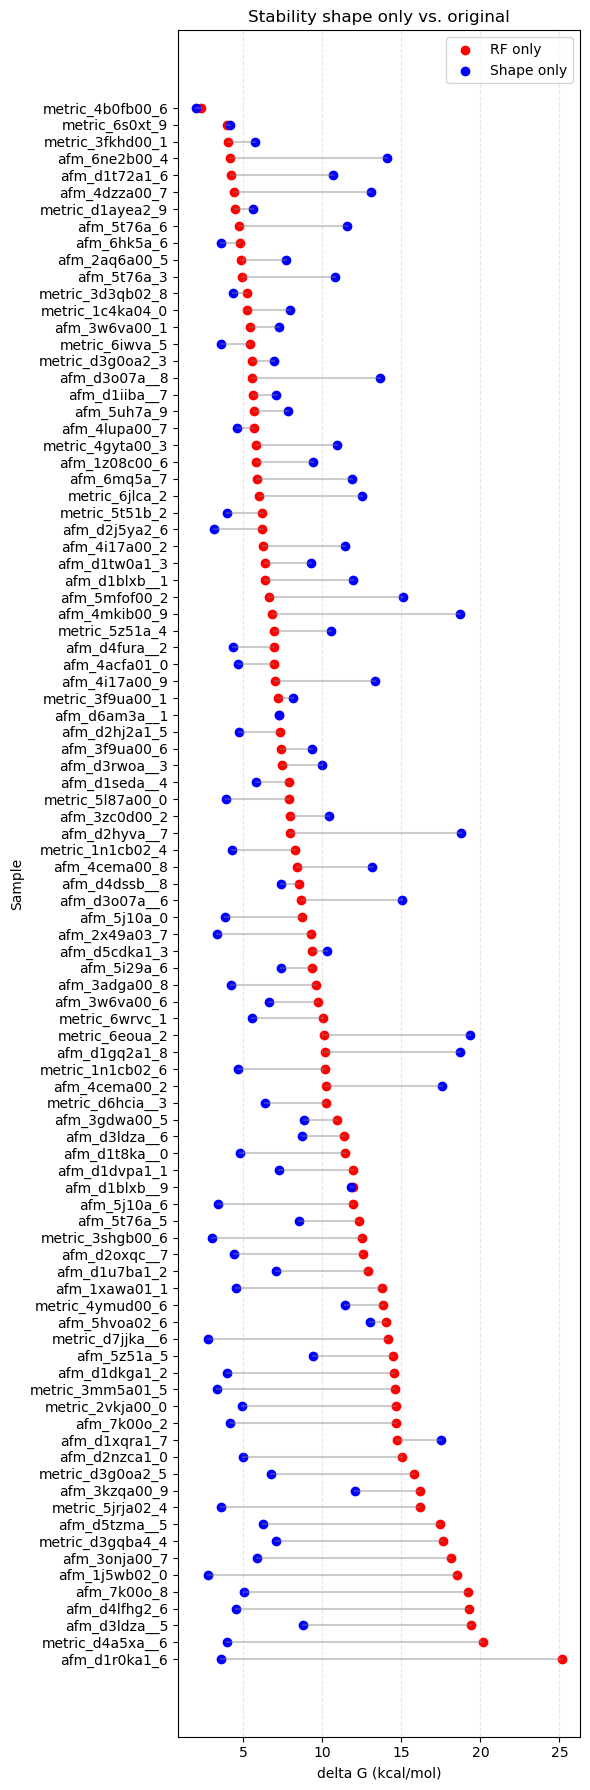

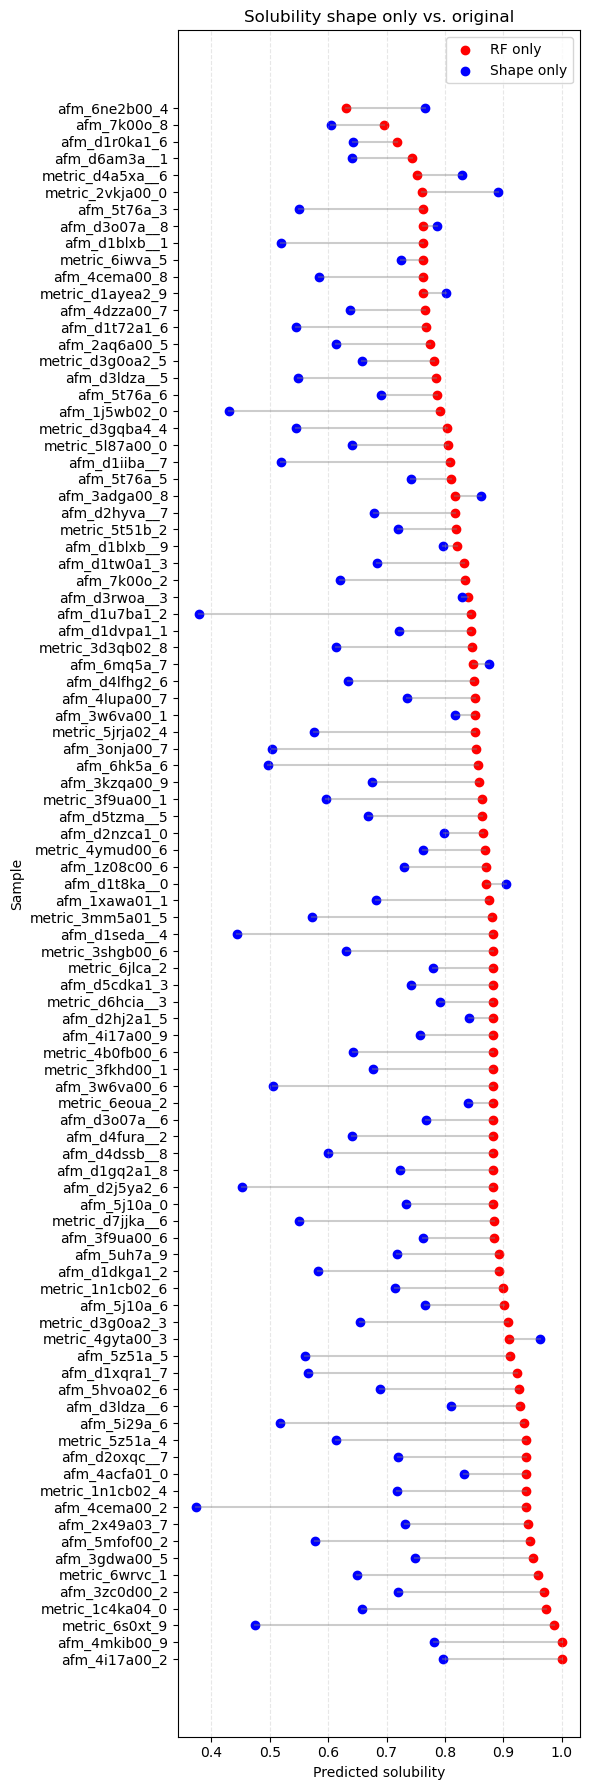

In [25]:
plot_df = pd.DataFrame({
    'file_ID': RF_shapedesign_df['file_ID'],
    'stab_RF': only_RF_df['delta_G'] ,
    'stab_shape': RF_shapedesign_df['stab_wo'] ,
    'hydro_RF' : only_RF_df['hydro_RF'] ,
    'hydro_shape' : RF_shapedesign_df['hydrophob_wo'] ,
    'sol_RF' : only_RF_df['sol_RF'] ,
    'sol_shape' : RF_shapedesign_df['solubility_wo']
})
plot_paired(plot_df,"stab_RF","stab_shape","Stability shape only vs. original","delta G (kcal/mol)","RF only","Shape only","stab_RF", size=(6,18))
plot_paired(plot_df,"sol_RF","sol_shape","Solubility shape only vs. original","Predicted solubility","RF only","Shape only","sol_RF", size=(6,18))

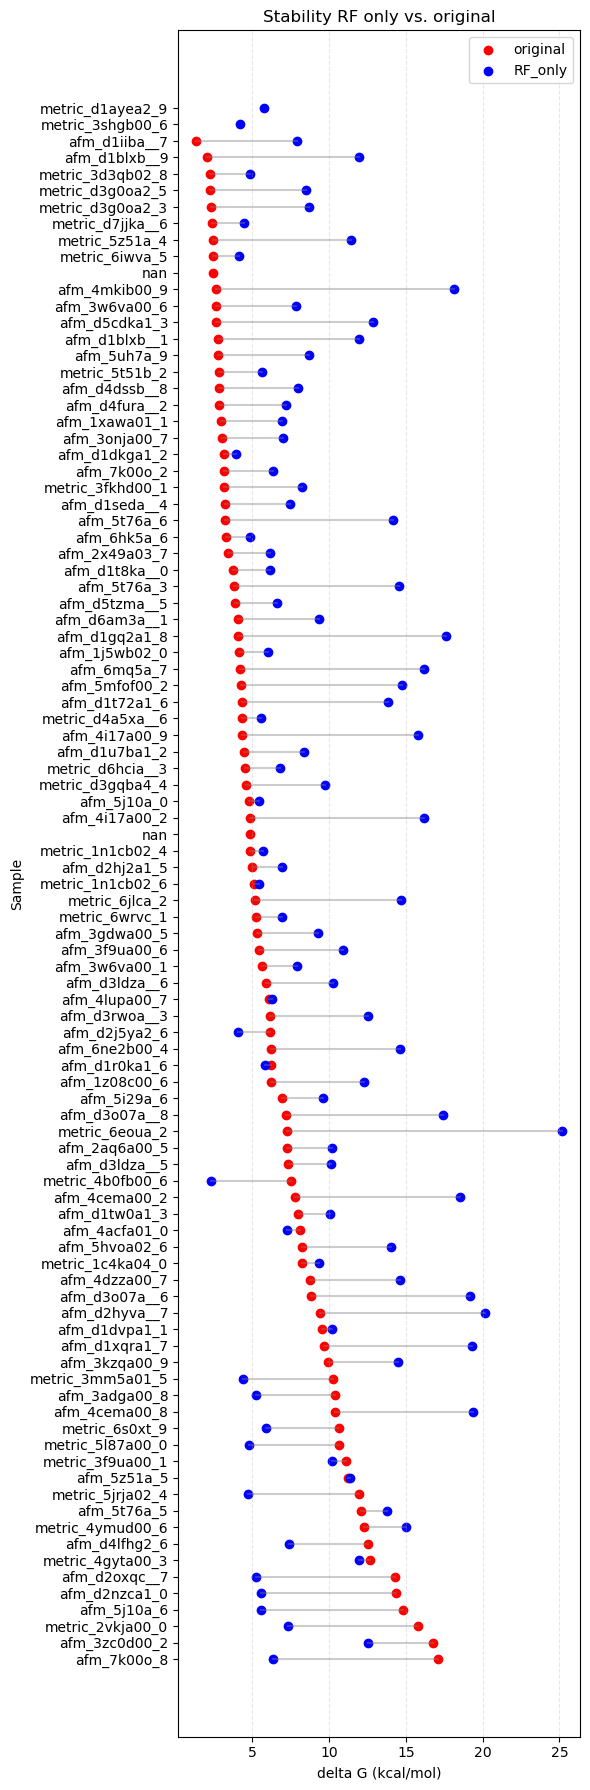

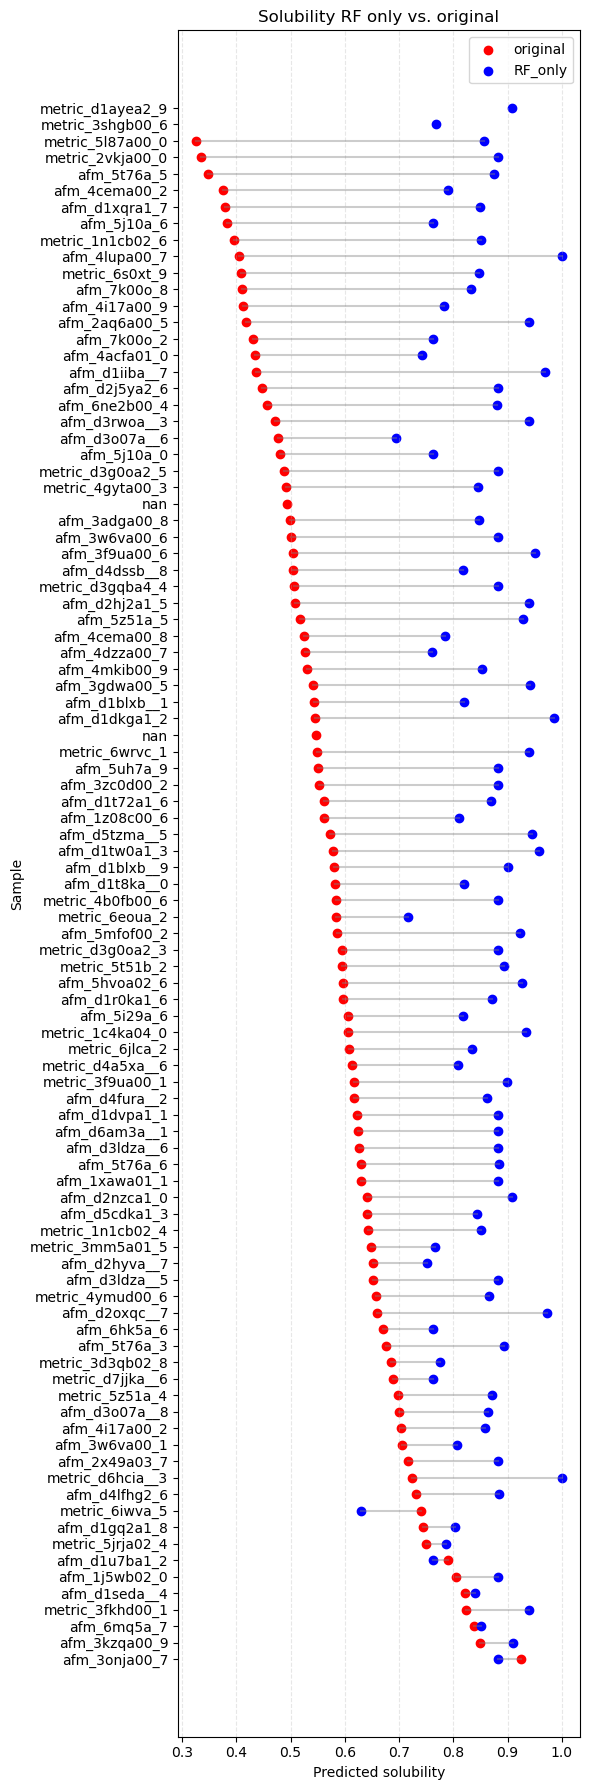

In [21]:
# Stability ######################################################
plot_df = pd.DataFrame({
    'file_ID': only_RF_df['file_ID'],
    'stab_orig': original_df['delta_G'],
    'stab_RF': only_RF_df['delta_G'] ,
    'hydro_orig' : original_df['hydro_orig'] ,
    'hydro_RF' : only_RF_df['hydro_RF'] ,
    'sol_orig' : original_df['sol_orig'] ,
    'sol_RF' : only_RF_df['sol_RF']
})
#plot_paired(df, col_wo, col_w, tittle, xlabel,label_wo,label_w,order_by)
plot_paired(plot_df,"stab_orig","stab_RF","Stability RF only vs. original","delta G (kcal/mol)","original","RF_only","stab_orig",size=(6,18))
plot_paired(plot_df,"sol_orig","sol_RF","Solubility RF only vs. original","Predicted solubility","original","RF_only","sol_orig",size=(6,18))


/tmp/ipykernel_607173/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_607173/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


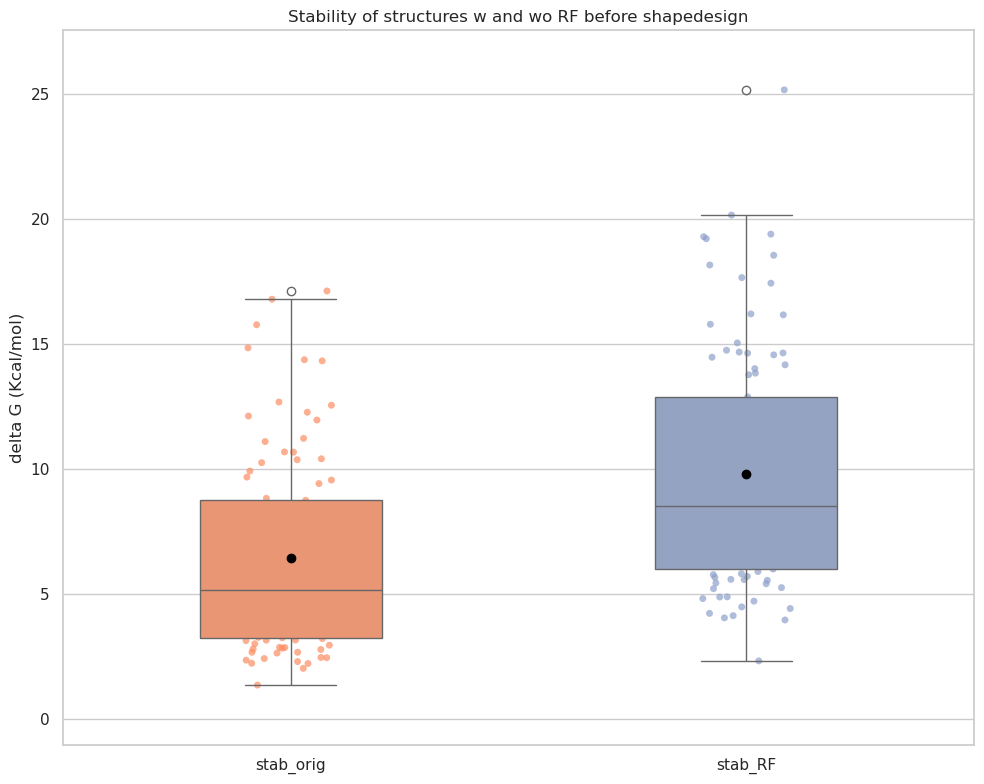

In [7]:
pLDDT_palette = {
    'stab_orig': "#fc8d62",   # soft orange
    'stab_RF': "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["stab_orig","stab_RF"],"delta G (Kcal/mol)",pLDDT_palette,"Stability of structures w and wo RF before shapedesign","delta G (Kcal/mol)",(10,8))


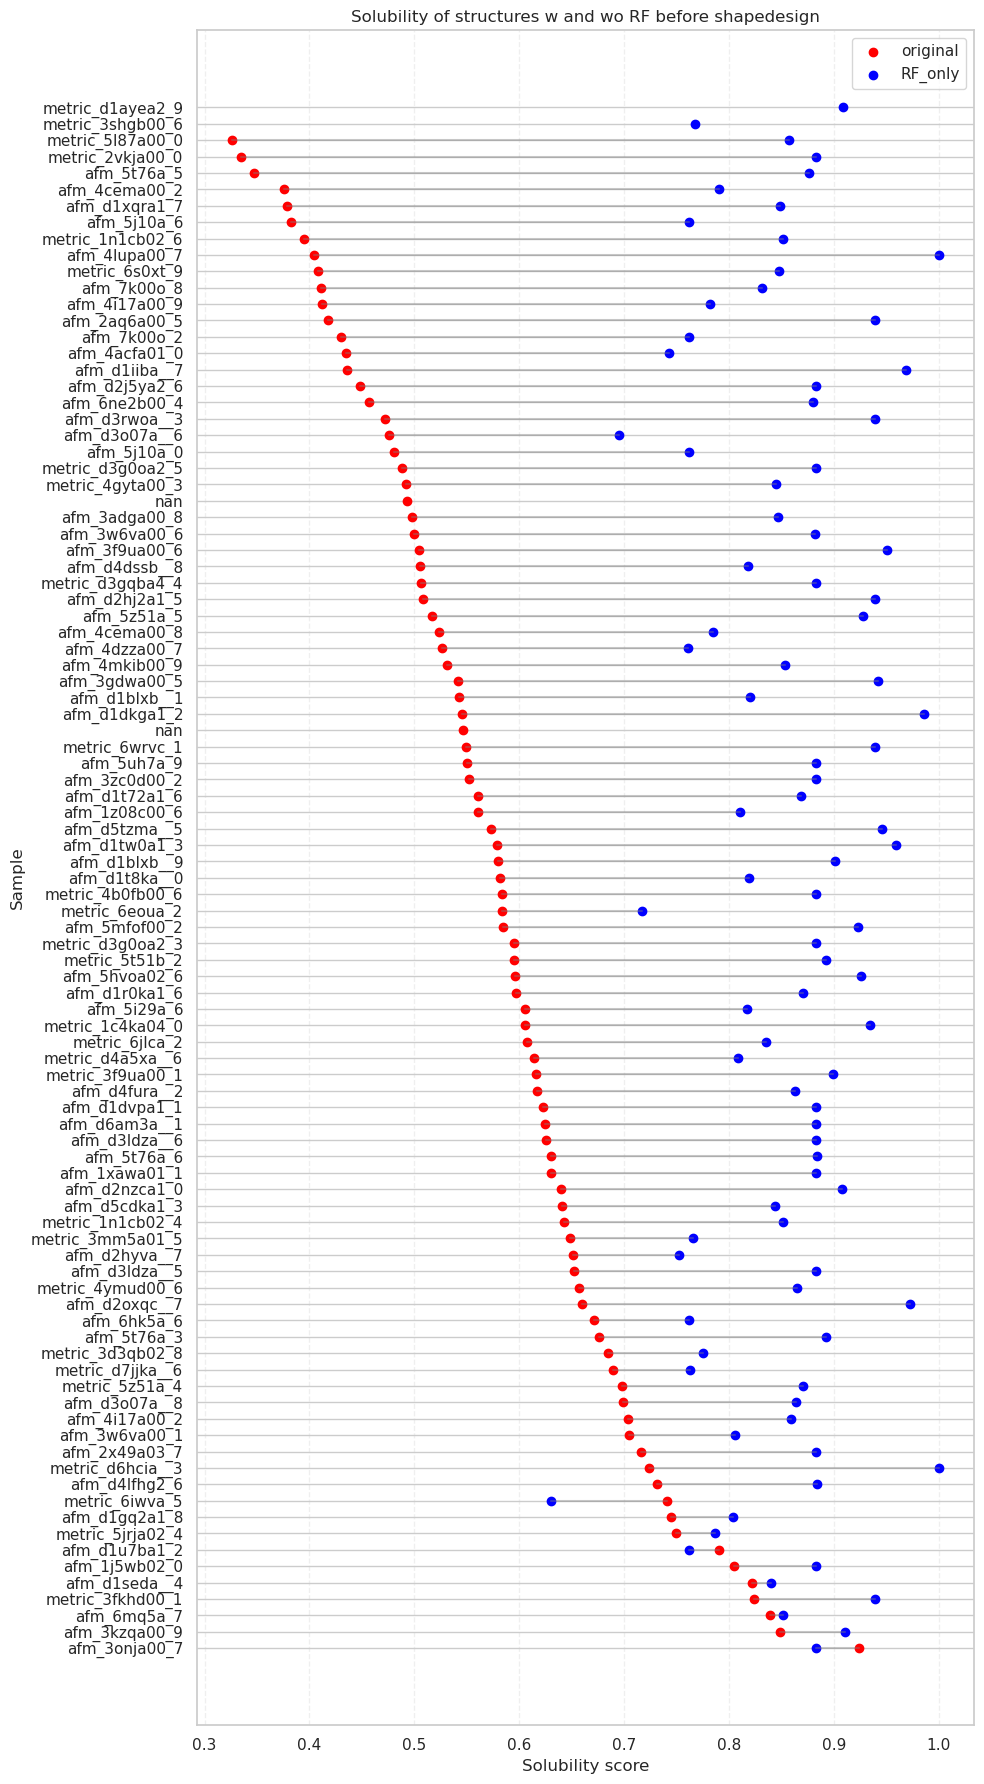

In [8]:
# Solubility #####################################################
#plot_paired(df, col_wo, col_w, tittle, xlabel,label_wo,label_w,order_by)
plot_paired(plot_df,"sol_orig","sol_RF","Solubility of structures w and wo RF before shapedesign","Solubility score","original","RF_only","sol_orig")


/tmp/ipykernel_607173/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_607173/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


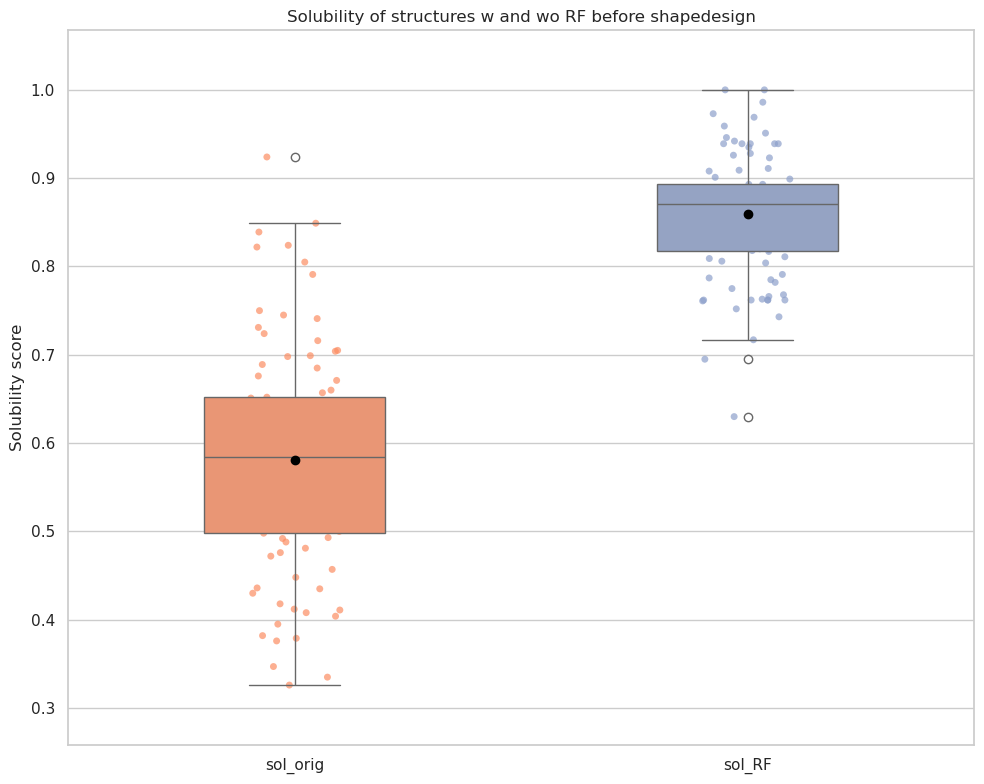

In [9]:
pLDDT_palette = {
    'sol_orig': "#fc8d62",   # soft orange
    'sol_RF': "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["sol_orig","sol_RF"],"Solubility score",pLDDT_palette,"Solubility of structures w and wo RF before shapedesign","Solubility score",(10,8))


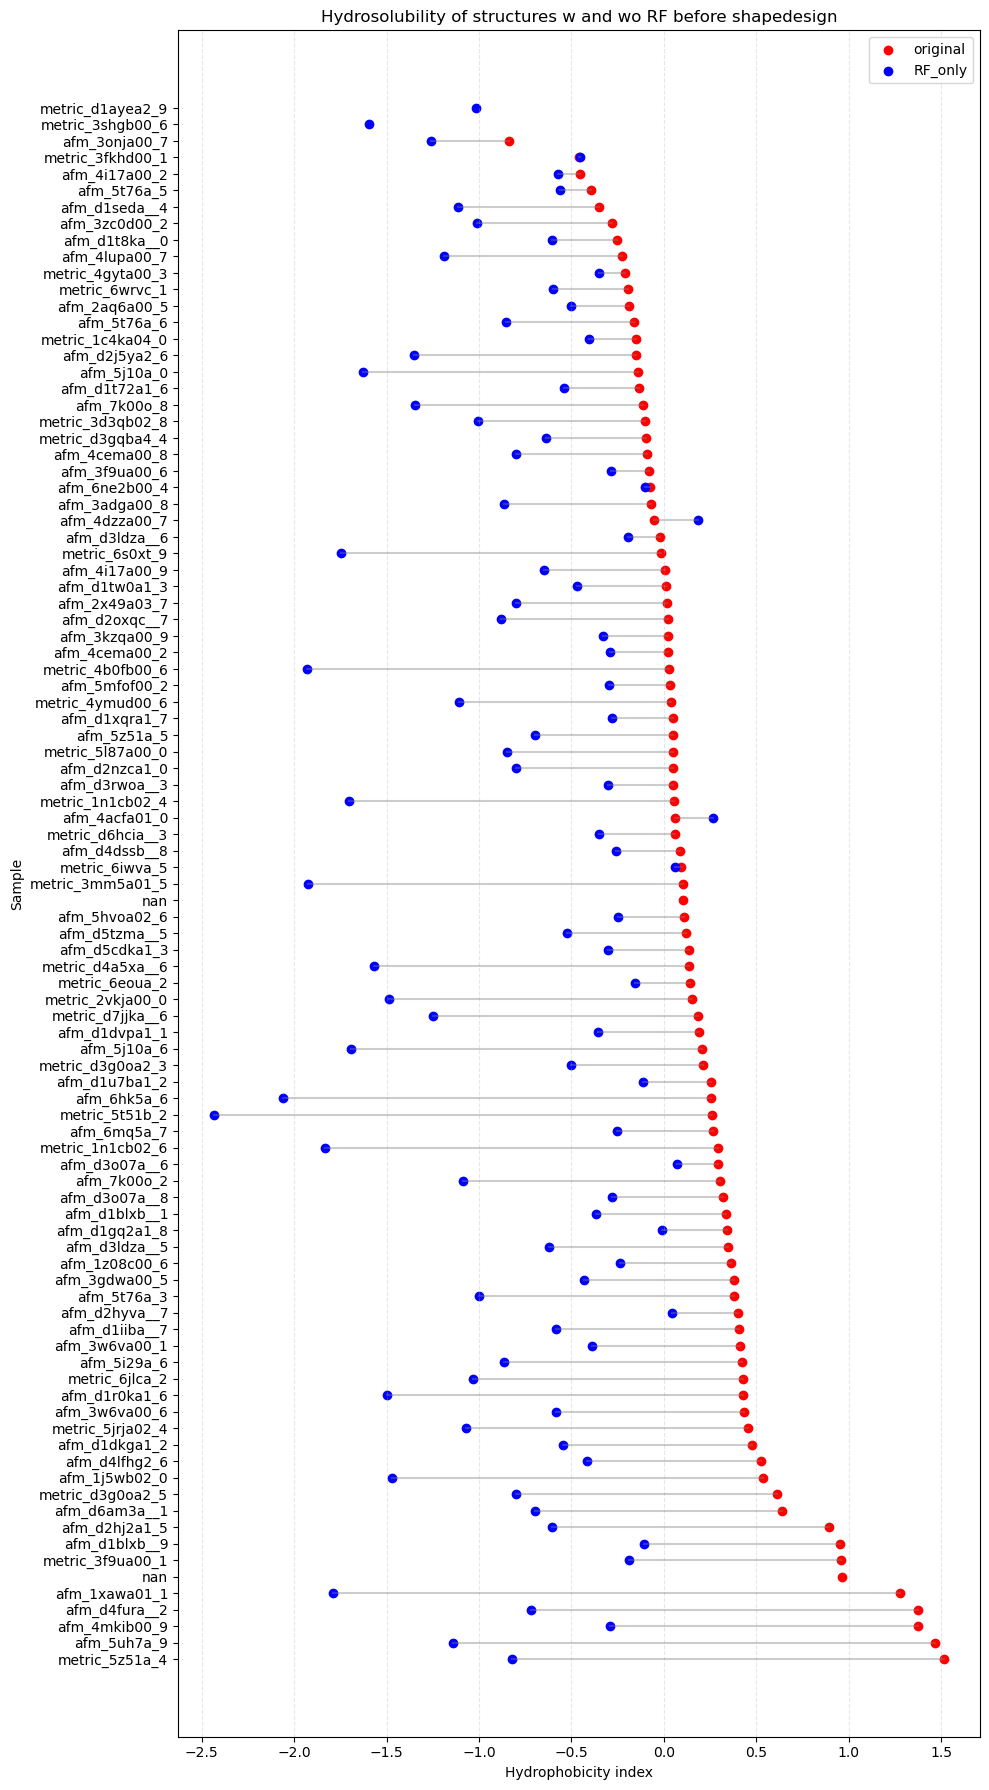

In [12]:
# Hydrophobicity #################################################
#plot_paired(df, col_wo, col_w, tittle, xlabel,label_wo,label_w,order_by)
plot_paired(plot_df,"hydro_orig","hydro_RF","Hydrosolubility of structures w and wo RF before shapedesign","Hydrophobicity index","original","RF_only","hydro_orig")

/tmp/ipykernel_558763/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_558763/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


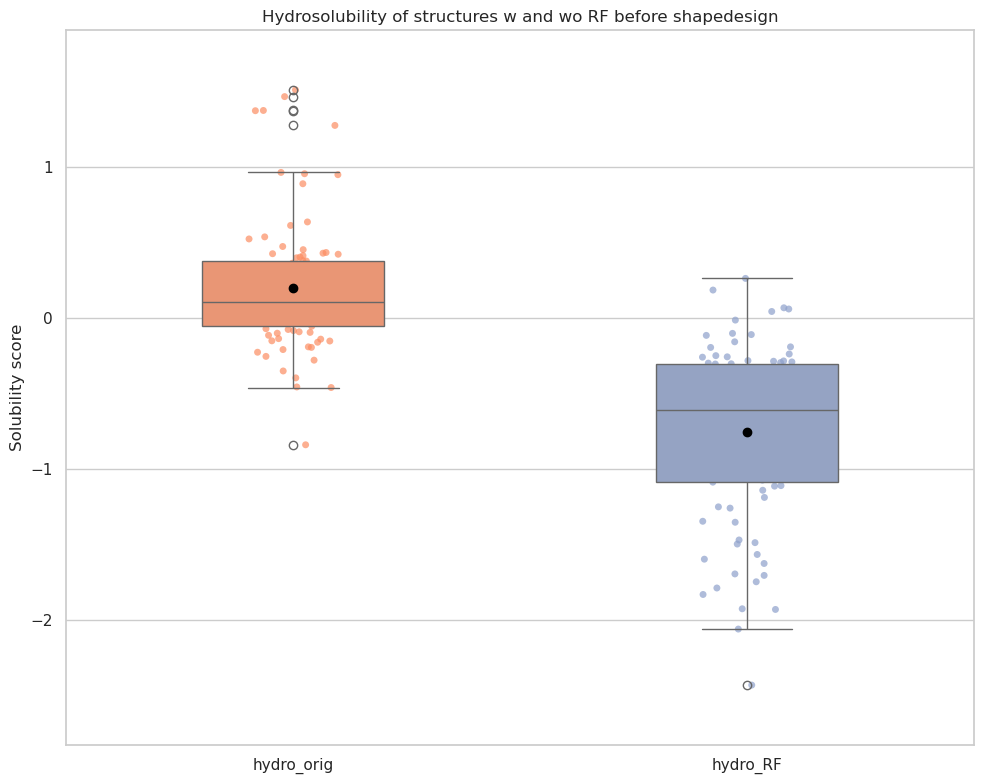

In [24]:
pLDDT_palette = {
    'hydro_orig': "#fc8d62",   # soft orange
    'hydro_RF': "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["hydro_orig","hydro_RF"],"Hydrosolubility score",pLDDT_palette,"Hydrosolubility of structures w and wo RF before shapedesign","Solubility score",(10,8))


In [13]:
# Stats ##########################################################

# Is the increase in stability significantly different?
# Is the solubility significantly different?
# Is the hydrophobicity significantly different ?
stats_stab = statistics_columns(plot_df,'stab_orig','stab_RF', paired = True)
stats_hydro = statistics_columns(plot_df,'hydro_orig','hydro_RF', paired = True)
stats_sol = statistics_columns(plot_df,'sol_orig','sol_RF', paired = True)

print(f"Stability: {stats_stab['star']}")
print(f"Hydrophobicity: {stats_hydro['star']}")
print(f"Solubility: {stats_sol['star']}")
print(stats_stab)


Stability: ***
Hydrophobicity: ***
Solubility: ***
{'test': 'Wilcoxon signed-rank', 'p_value': 1.6880785875309786e-06, 'star': '***', 'statistic': 936.0, 'mean_difference': -3.3898579510582048, 'effect_size': -0.4838709677419355, 'normality': {'col1': 2.6688962042865197e-06, 'col2': 6.262272027297715e-05}, 'equal_variance': None}


**Conclusions**:

## Original vs RF diffusion + shapedesign
---

In [27]:
RF_shapedesign_df.head()

Unnamed: 0        file_ID  RMSD_pred-ex_w  Tm_pred-ex_w  RMSD_pred-ex_wo  \
68          68  afm_1j5wb02_0        0.599369      0.002541        10.614386   
73          73  afm_1xawa01_1        3.075050      0.001220         0.830595   
22          22  afm_1z08c00_6        0.606730      0.002552         4.739056   
80          80  afm_2aq6a00_5        5.981182      0.003677        10.695934   
60          60  afm_2x49a03_7        0.571145      0.002554         7.991688   

    Tm_pred-ex_wo  RMSD_w_wo   Tm_w_wo  RMSD_pred-og_w  Tm_pred-og_w  ...  \
68       0.004241  12.942104  0.050570        2.619047      0.074926  ...   
73       0.001506   8.338593  0.039192       10.733453      0.033778  ...   
22       0.001326   7.232922  0.045288        1.957536      0.104551  ...   
80       0.003690   9.954436  0.122921        2.343406      0.101876  ...   
60       0.002728   8.468475  0.052905        3.846957      0.061216  ...   

    solubility_wo  hydrophob_w  hydrophob_wo    pLDDT_w   pLDDT_wo     stab_w  \
68          0.739    -0.250667      0.278912  87.383320  83.999636   4.123708   
73          0.806    -1.423158     -0.216146  67.051515  93.249062   5.139944   
22          0.509    -0.007273      0.267105  91.280062  55.305626  12.338762   
80          0.514    -0.288732      0.142995  65.641452  75.671273   7.336897   
60          0.649    -0.706977     -0.011299  85.686827  83.039407   5.074369   

      stab_wo  stab_orig  delta_delta_g_w  delta_delta_g_wo  
68   3.869791   2.442101         1.681607          1.427690  
73   5.287238   2.998920         2.141024          2.288318  
22  10.063658   8.098727         4.240036          1.964932  
80   8.736781   6.228593         1.108304          2.508189  
60   4.471402   3.255634         1.818735          1.215768  

[5 rows x 23 columns]

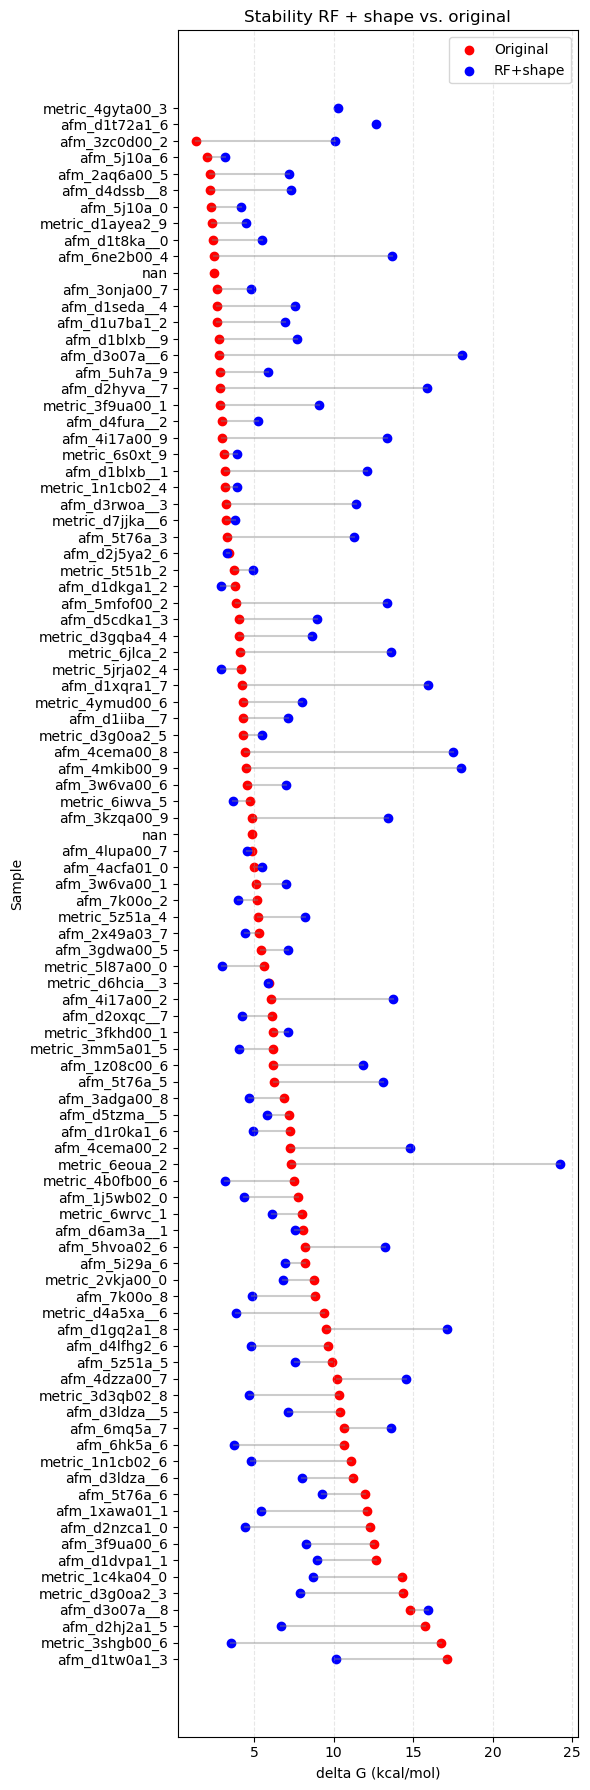

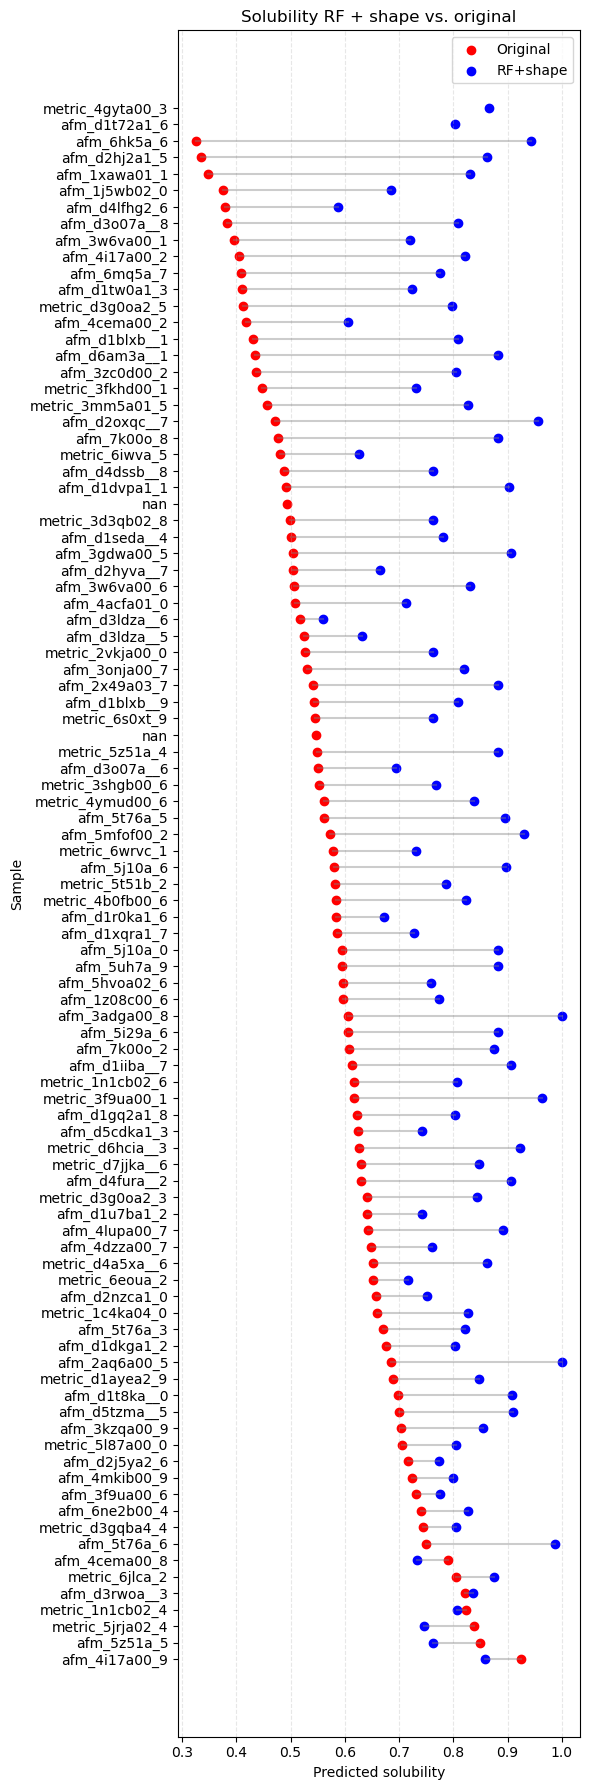

In [23]:
# Stability ######################################################
plot_df = pd.DataFrame({
    'file_ID': RF_shapedesign_df['file_ID'],
    'stab_orig': original_df['delta_G'],
    'stab_RF_shape': RF_shapedesign_df['stab_w'] ,
    'hydro_orig' : original_df['hydro_orig'] ,
    'hydro_RF_shape' : RF_shapedesign_df['hydrophob_w'] ,
    'sol_orig' : original_df['sol_orig'] ,
    'sol_RF_shape' : RF_shapedesign_df['solubility_w']
})
plot_paired(plot_df,"stab_orig","stab_RF_shape","Stability RF + shape vs. original","delta G (kcal/mol)","Original","RF+shape","stab_orig",size = (6,18))
plot_paired(plot_df,"sol_orig","sol_RF_shape","Solubility RF + shape vs. original","Predicted solubility","Original","RF+shape","sol_orig",size = (6,18))


/tmp/ipykernel_558763/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_558763/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


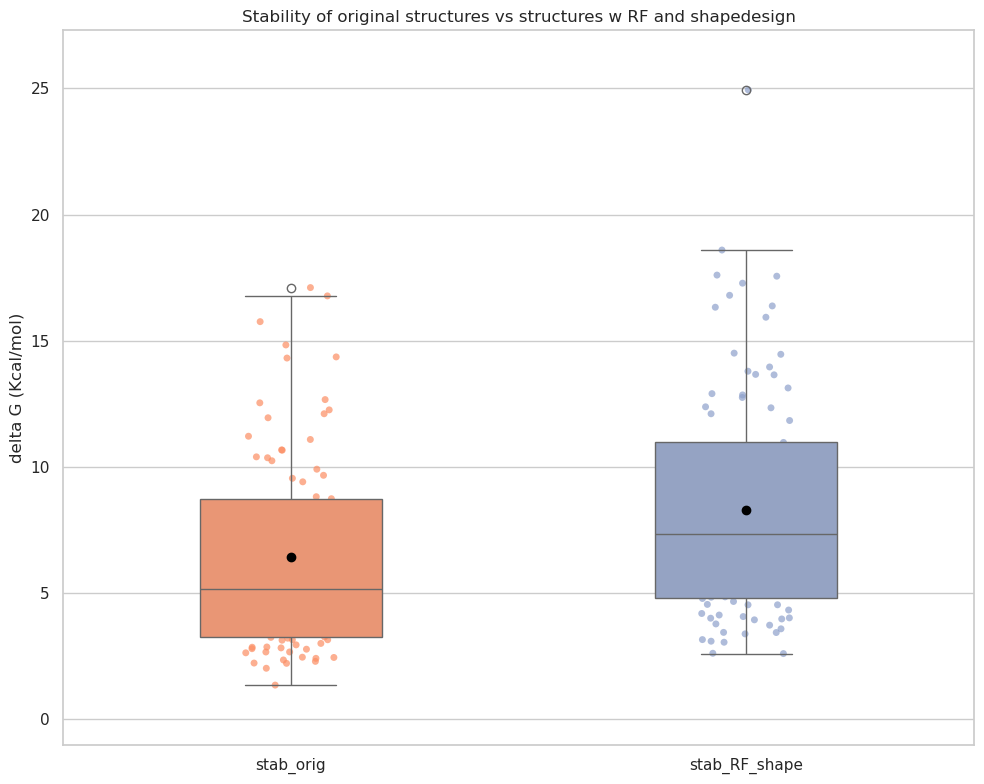

In [37]:
pLDDT_palette = {
    'stab_orig': "#fc8d62",   # soft orange
    'stab_RF_shape': "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["stab_orig","stab_RF_shape"],"delta G (Kcal/mol)",pLDDT_palette,"Stability of original structures vs structures w RF and shapedesign","delta G (Kcal/mol)",(10,8))


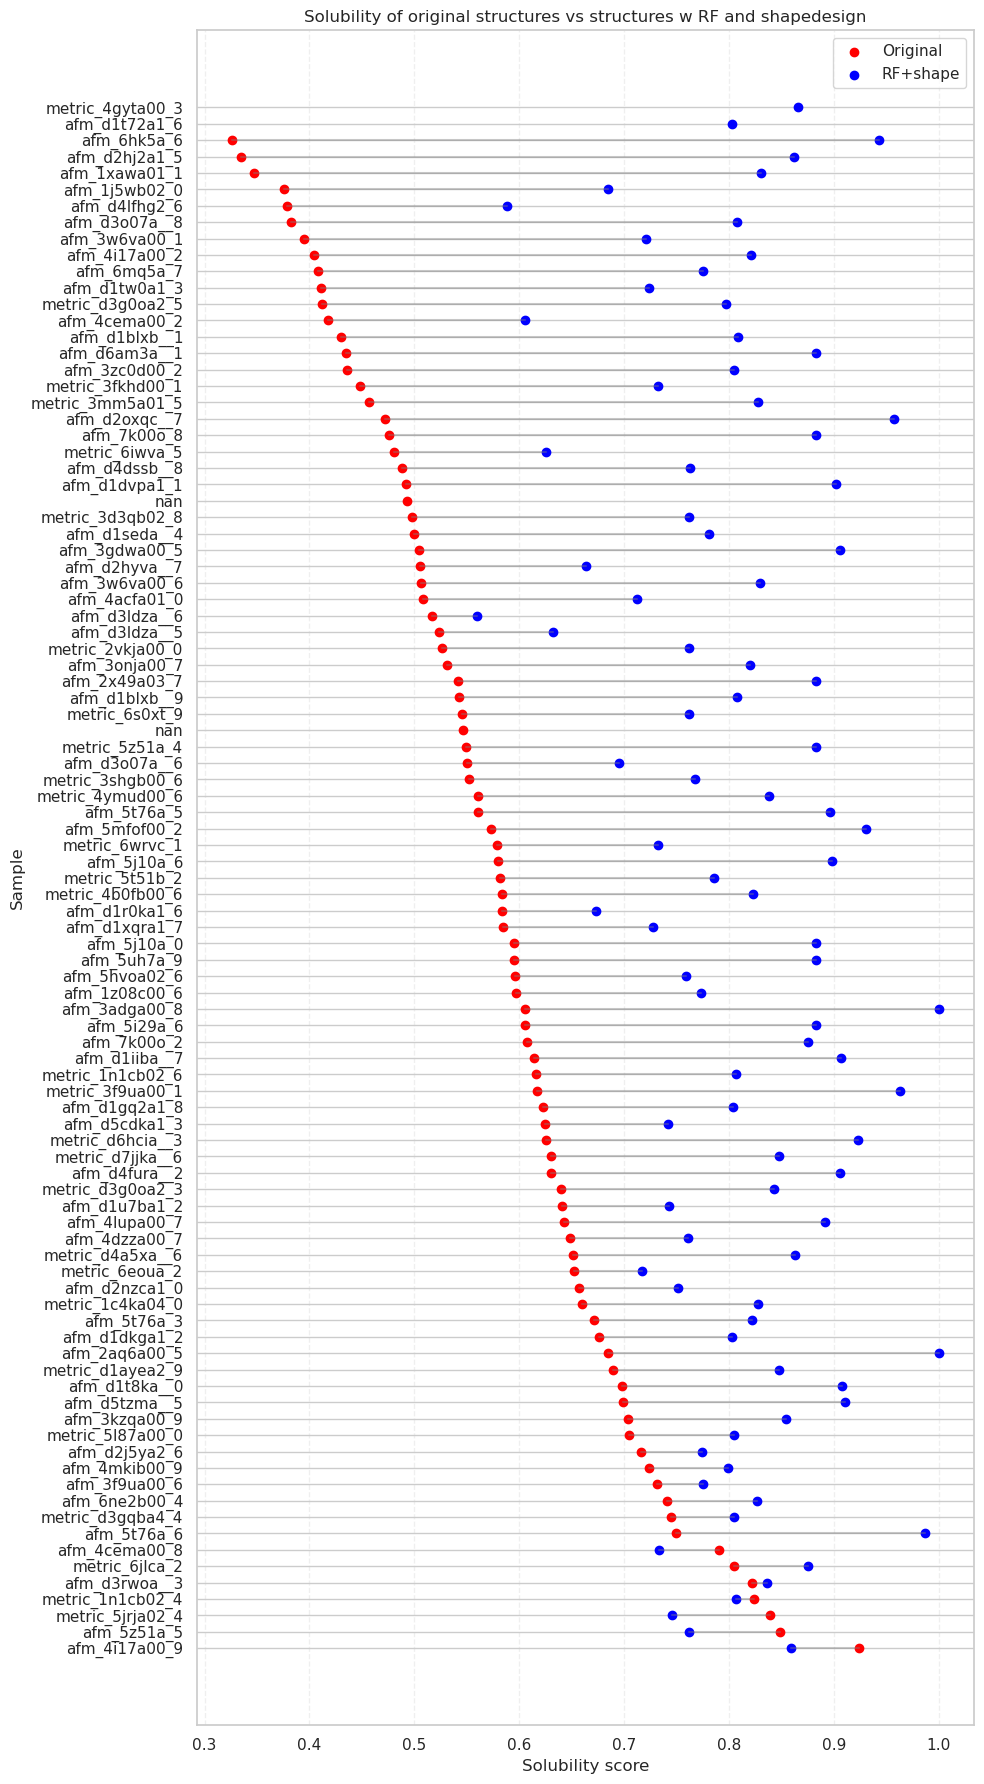

In [38]:
# Solubility #####################################################
plot_paired(plot_df,"sol_orig","sol_RF_shape","Solubility of original structures vs structures w RF and shapedesign","Solubility score","Original","RF+shape","sol_orig")


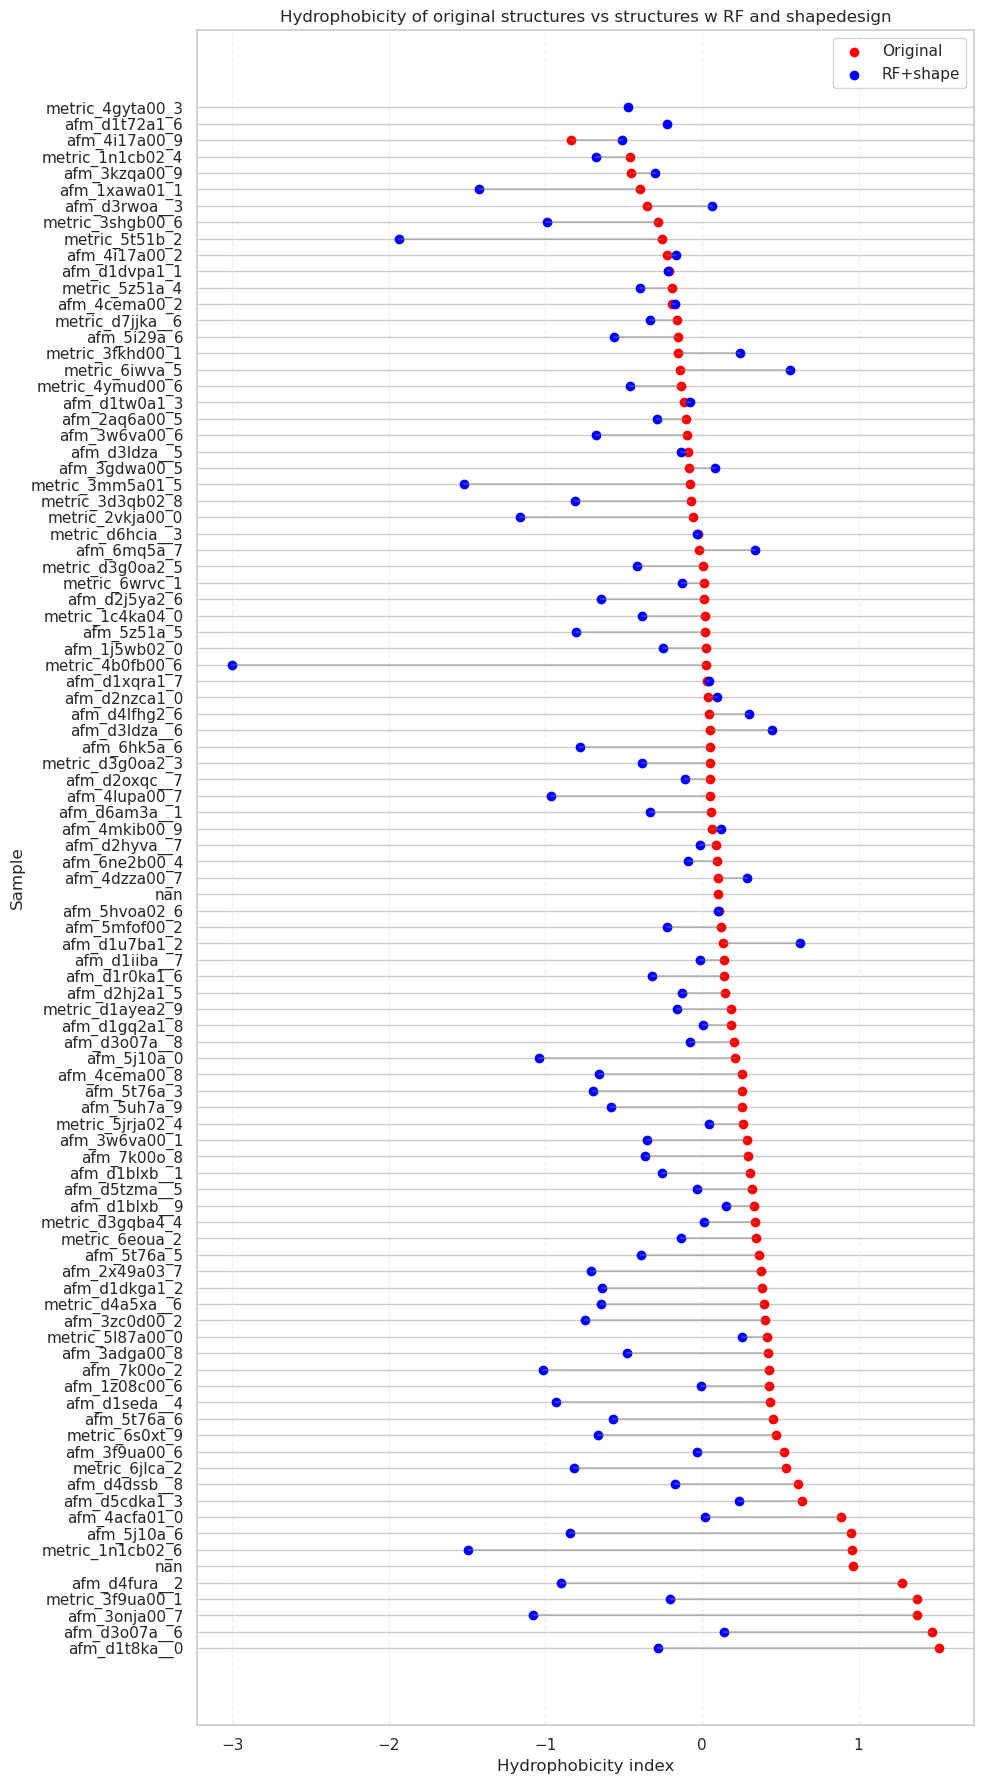

In [39]:
# Hydrophobicity #################################################
plot_paired(plot_df,"hydro_orig","hydro_RF_shape","Hydrophobicity of original structures vs structures w RF and shapedesign","Hydrophobicity index","Original","RF+shape","hydro_orig")


In [7]:
# Stats ##########################################################

# Is the increase in stability significantly different?
# Is the solubility significantly different?
# Is the hydrophobicity significantly different ?

stats_stab = statistics_columns(plot_df,'stab_orig','stab_RF_shape', paired = True)
stats_hydro = statistics_columns(plot_df,'hydro_orig','hydro_RF_shape', paired = True)
stats_sol = statistics_columns(plot_df,'sol_orig','sol_RF_shape', paired = True)

print(f"Stability: {stats_stab['star']}")
print(f"Hydrophobicity: {stats_hydro['star']}")
print(f"Solubility: {stats_sol['star']}")
print(stats_stab)

Stability: **
Hydrophobicity: ***
Solubility: ***
{'test': 'Wilcoxon signed-rank', 'p_value': 0.0013681077603894412, 'star': '**', 'statistic': 1350.0, 'mean_difference': -1.885992572881512, 'effect_size': -0.3333333333333333, 'normality': {'col1': 2.6688962042865197e-06, 'col2': 3.041996412825206e-06}, 'equal_variance': None}


**Conclusions**:

## Original vs shapedesign only
---

In [5]:
RF_shapedesign_df.head()

Unnamed: 0        file_ID  RMSD_pred-ex_w  Tm_pred-ex_w  RMSD_pred-ex_wo  \
68          68  afm_1j5wb02_0        0.747700      0.003066         1.298362   
73          73  afm_1xawa01_1        7.675167      0.001449         0.947814   
22          22  afm_1z08c00_6        0.629387      0.002427        10.349679   
80          80  afm_2aq6a00_5        6.173714      0.004435        15.314217   
60          60  afm_2x49a03_7        0.590588      0.002280         1.492028   

    Tm_pred-ex_wo  RMSD_w_wo   Tm_w_wo  RMSD_pred-og_w  Tm_pred-og_w  ...  \
68       0.002638   7.896567  0.022528        2.565425      0.079256  ...   
73       0.003845   9.384610  0.044573       13.771330      0.034715  ...   
22       0.003130  17.918531  0.031059        1.949959      0.091867  ...   
80       0.002315   6.050992  0.050558        2.109405      0.102796  ...   
60       0.002783  10.771157  0.033173        3.816582      0.065512  ...   

    solubility_wo  hydrophob_w  hydrophob_wo    pLDDT_w   pLDDT_wo     stab_w  \
68          0.430    -0.250667      0.020085  87.368256  88.026088   4.339830   
73          0.682    -1.423158      0.101130  66.714935  87.683176   5.427474   
22          0.730    -0.007273      0.171014  91.230560  83.999401  11.870998   
80          0.613    -0.288732      0.287640  65.636093  56.867051   7.182795   
60          0.731    -0.706977     -0.154745  85.753669  86.316638   4.431007   

     stab_wo  stab_orig  delta_delta_g_w  delta_delta_g_wo  
68  2.750474   2.442101         1.897728          0.308373  
73  4.533685   2.998920         2.428554          1.534765  
22  9.371406   8.098727         3.772271          1.272679  
80  7.706514   6.228593         0.954203          1.477921  
60  3.296768   3.255634         1.175373          0.041134  

[5 rows x 23 columns]

In [6]:
original_df.head()

Unnamed: 0        file_ID  \
83          83  afm_1j5wb02_0   
14          14  afm_1xawa01_1   
66          66  afm_1z08c00_6   
62          62  afm_2aq6a00_5   
25          25  afm_2x49a03_7   

                                                  seq  length  sol_orig  \
83  VYELVANYEIWKELAKEAIKNNAYLTAKEFLKNAINTMAPLIACGI...      75     0.741   
14  DQQRQLYKRNFDTGLQEYKSLESVFEELACEQAKMHTEIVDYRPES...      95     0.924   
66  PYYFKVVLLGPPICGKTSLVLRYCENKFNDNPIDTSGASSLQVTLN...     165     0.435   
62  QDEIVLLVLASSTYAGIAAPGIDGVFGGRRYPAAFEIDRKTVCAVL...     142     0.561   
25  LIEEATRAMLYAMEKEYPWLVREVMSYVPLHMILTLLQILKCAGVS...      86     0.671   

    hydro_orig   delta_G  
83    0.093333  2.442101  
14   -0.838947  2.998920  
66    0.060606  8.098727  
62    0.363380  6.228592  
25    0.253488  3.255634

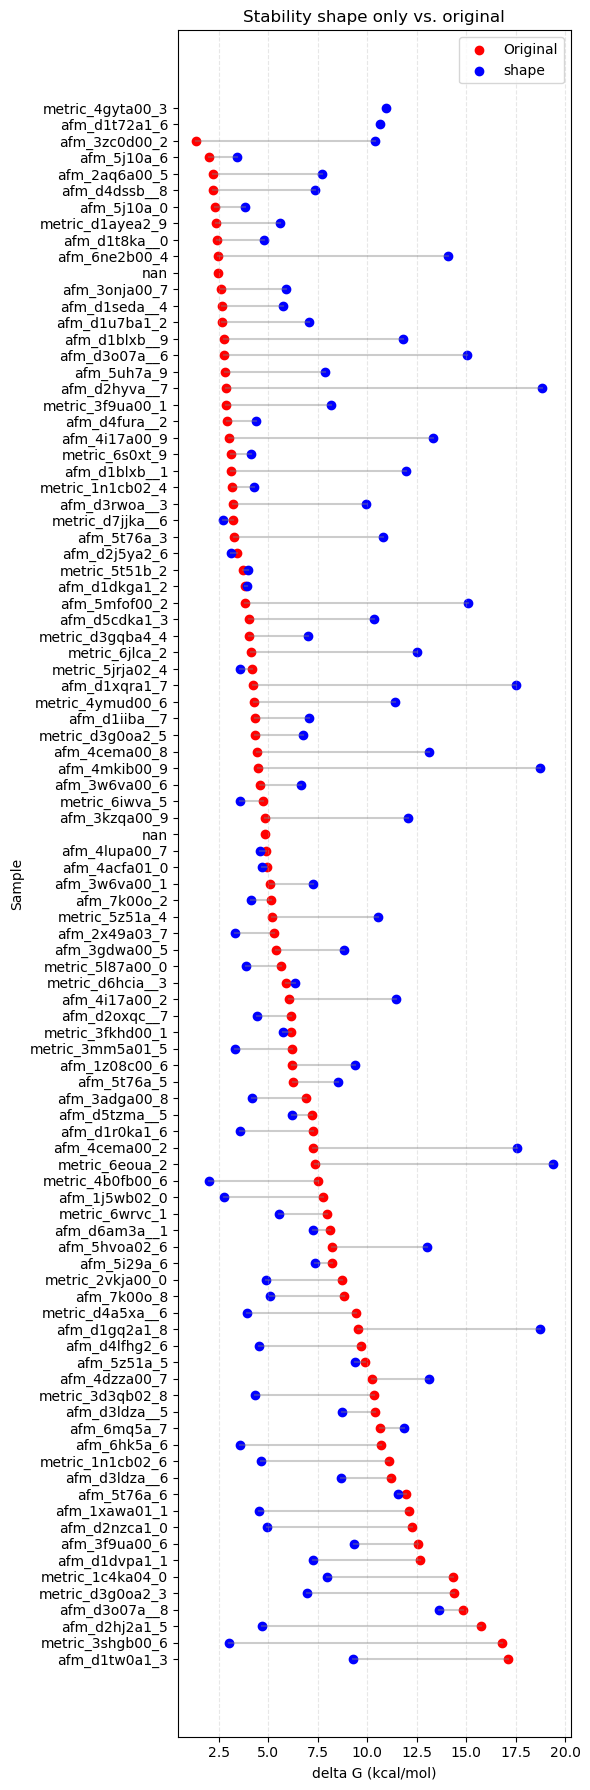

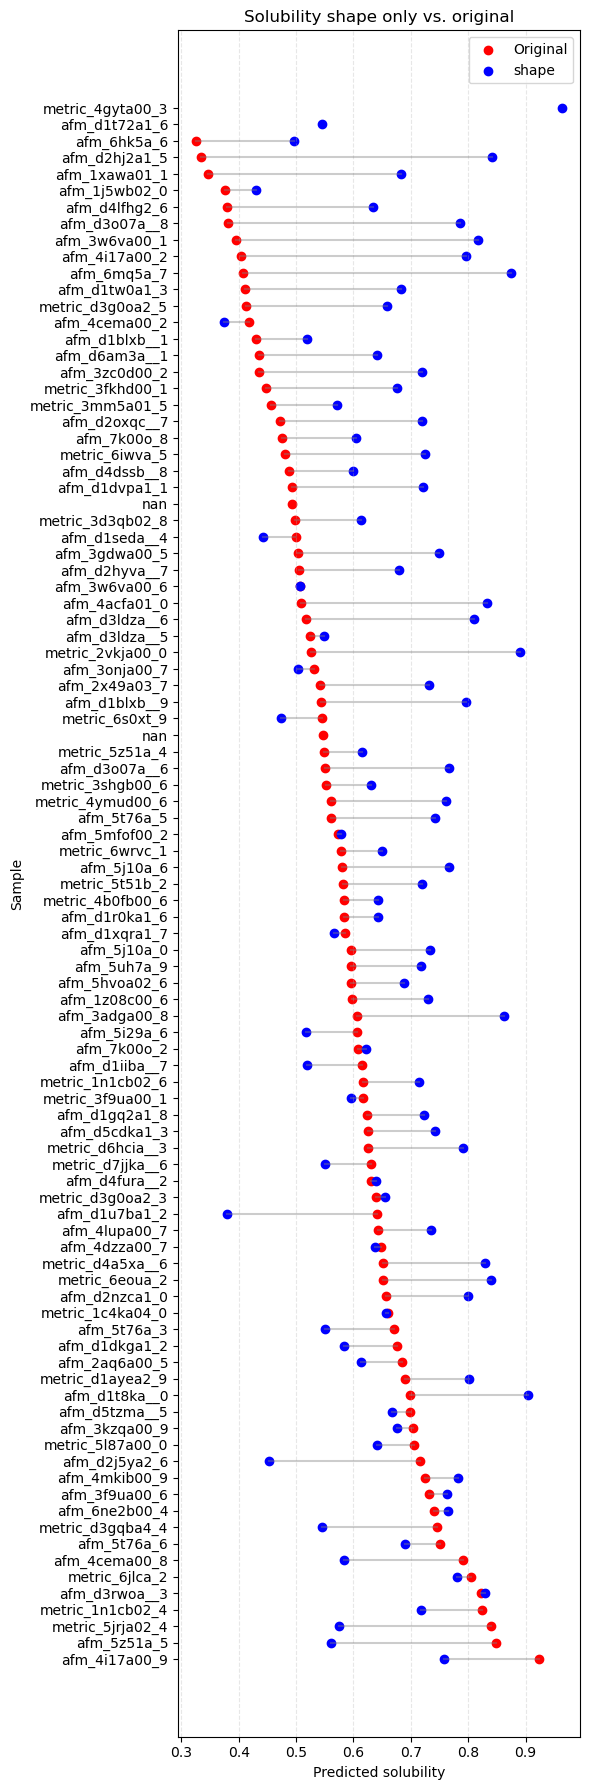

In [24]:
# Stability ######################################################
plot_df = pd.DataFrame({
    'file_ID': RF_shapedesign_df['file_ID'],
    'stab_orig': original_df['delta_G'],
    'stab_shape': RF_shapedesign_df['stab_wo'] ,
    'hydro_orig' : original_df['hydro_orig'] ,
    'hydro_shape' : RF_shapedesign_df['hydrophob_wo'] ,
    'sol_orig' : original_df['sol_orig'] ,
    'sol_shape' : RF_shapedesign_df['solubility_wo']
})
plot_paired(plot_df,"stab_orig","stab_shape","Stability shape only vs. original","delta G (kcal/mol)","Original","shape","stab_orig", size=(6,18))
plot_paired(plot_df,"sol_orig","sol_shape","Solubility shape only vs. original","Predicted solubility","Original","shape","sol_orig", size=(6,18))

In [ ]:
# Solubility #####################################################

In [ ]:
# Hydrophobicity #################################################


In [ ]:
# Stats ##########################################################

# Is the increase in stability significantly different?
# Is the solubility significantly different?
# Is the hydrophobicity significantly different?

**Conclusions**:

## RF diffusion + shapedesign vs. shapedesign only
---

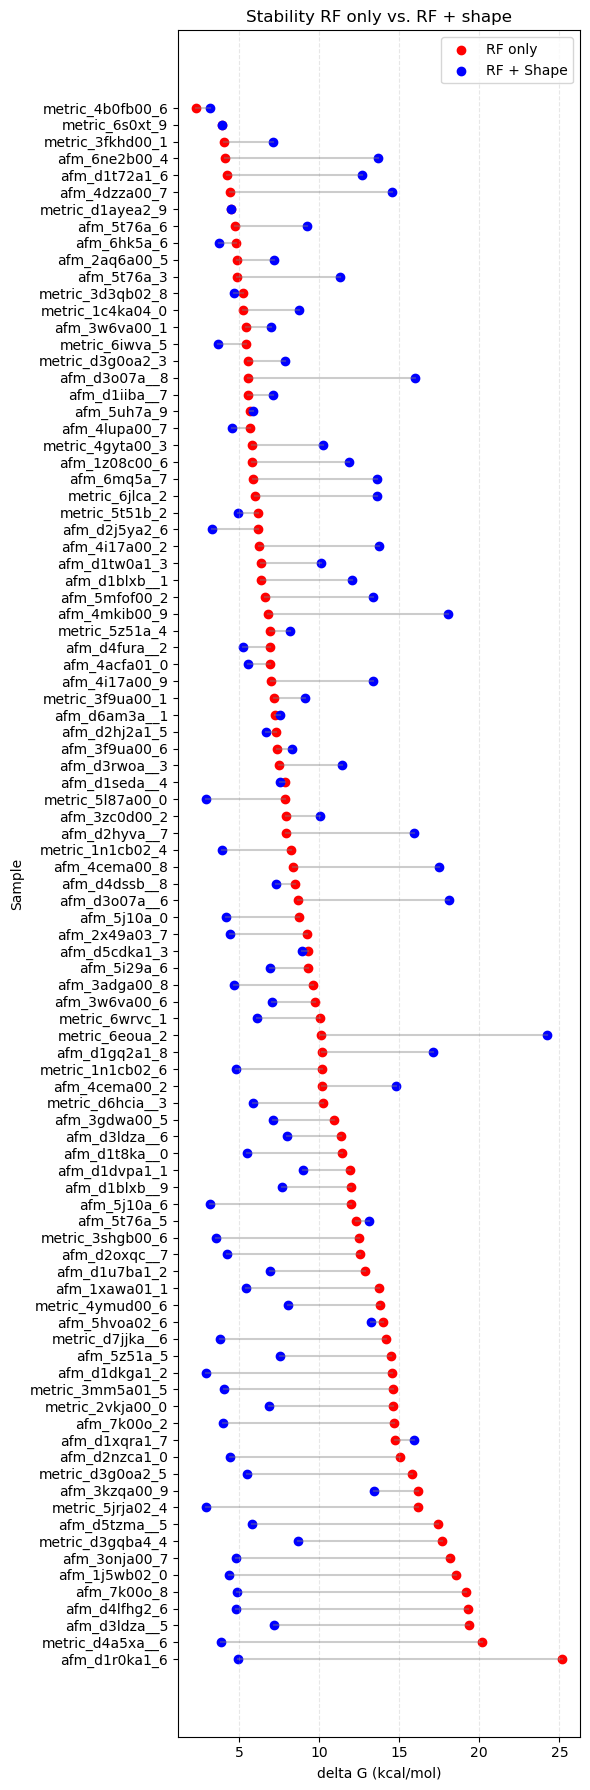

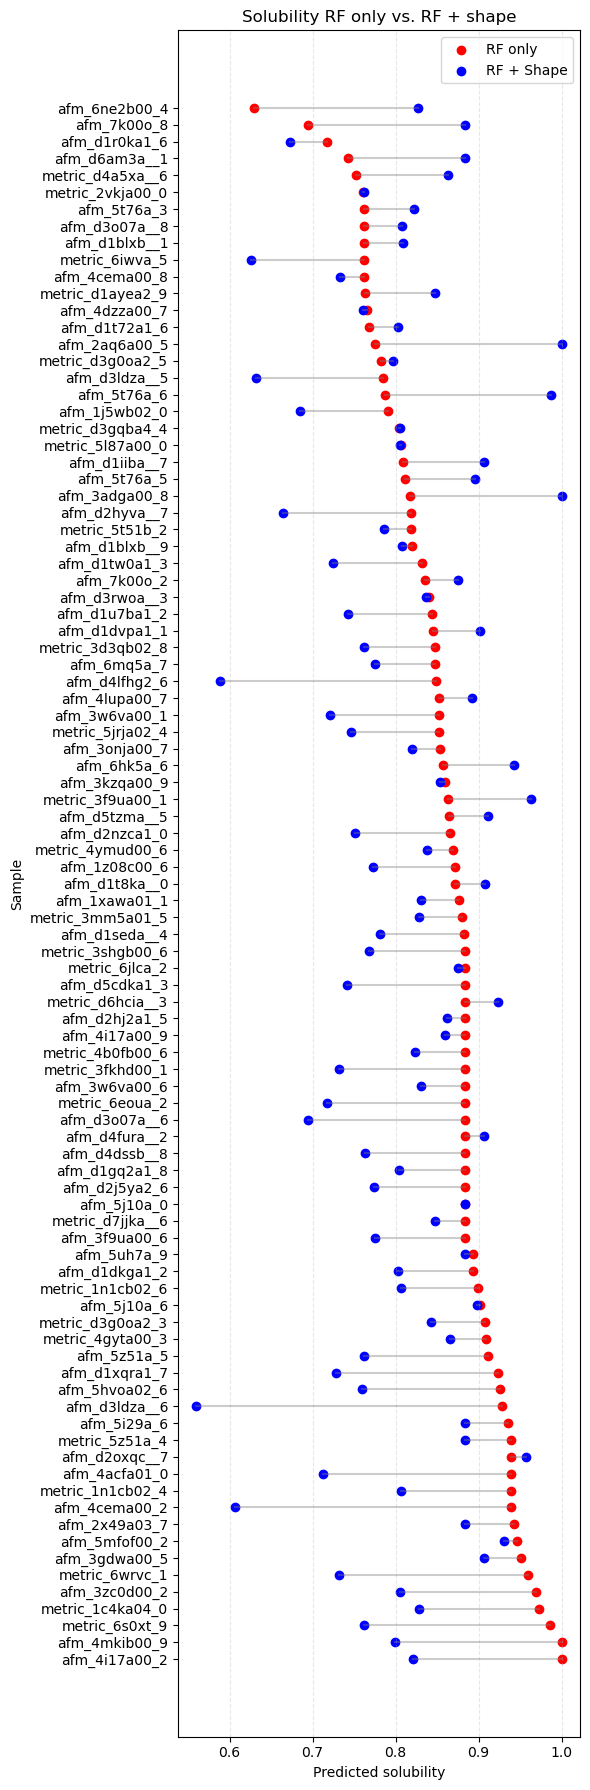

In [27]:
# RF only vs RF shape
plot_df = pd.DataFrame({
    'file_ID': RF_shapedesign_df['file_ID'],
    'stab_RF': only_RF_df['delta_G'] ,
    'stab_shape': RF_shapedesign_df['stab_w'] ,
    'hydro_RF' : only_RF_df['hydro_RF'] ,
    'hydro_shape' : RF_shapedesign_df['hydrophob_w'] ,
    'sol_RF' : only_RF_df['sol_RF'] ,
    'sol_shape' : RF_shapedesign_df['solubility_w']
})
plot_paired(plot_df,"stab_RF","stab_shape","Stability RF only vs. RF + shape","delta G (kcal/mol)","RF only","RF + Shape","stab_RF", size=(6,18))
plot_paired(plot_df,"sol_RF","sol_shape","Solubility RF only vs. RF + shape","Predicted solubility","RF only","RF + Shape","sol_RF", size=(6,18))

In [7]:
RF_shapedesign_df.head()

Unnamed: 0        file_ID  RMSD_pred-ex_w  Tm_pred-ex_w  RMSD_pred-ex_wo  \
68          68  afm_1j5wb02_0        0.747700       0.89914         1.298362   
73          73  afm_1xawa01_1        7.675167       0.50864         0.947814   
22          22  afm_1z08c00_6        0.629387       0.97985        10.349679   
80          80  afm_2aq6a00_5        6.173714       0.55905        15.314217   
60          60  afm_2x49a03_7        0.590588       0.90764         1.492028   

    Tm_pred-ex_wo  RMSD_w_wo  Tm_w_wo  RMSD_pred-og_w  Tm_pred-og_w  ...  \
68        0.86202   7.896567  0.46488        2.565425       0.67247  ...   
73        0.93520   9.384610  0.36656       13.771330       0.53395  ...   
22        0.50047  17.918531  0.39261        1.949959       0.68985  ...   
80        0.30513   6.050992  0.27003        2.109405       0.60737  ...   
60        0.86770  10.771157  0.31982        3.816581       0.52703  ...   

    solubility_wo  hydrophob_w  hydrophob_wo    pLDDT_w   pLDDT_wo     stab_w  \
68          0.430    -0.250667      0.020085  87.368256  88.026088   4.339829   
73          0.682    -1.423158      0.101130  66.714935  87.683176   5.427475   
22          0.730    -0.007273      0.171014  91.230560  83.999401  11.870998   
80          0.613    -0.288732      0.287640  65.636093  56.867051   7.182796   
60          0.731    -0.706977     -0.154745  85.753669  86.316638   4.431008   

     stab_wo  stab_orig  delta_delta_g_w  delta_delta_g_wo  
68  2.750474   2.442101         1.897728          0.308373  
73  4.533685   2.998920         2.428554          1.534765  
22  9.371406   8.098727         3.772271          1.272679  
80  7.706514   6.228592         0.954204          1.477922  
60  3.296768   3.255634         1.175374          0.041134  

[5 rows x 23 columns]

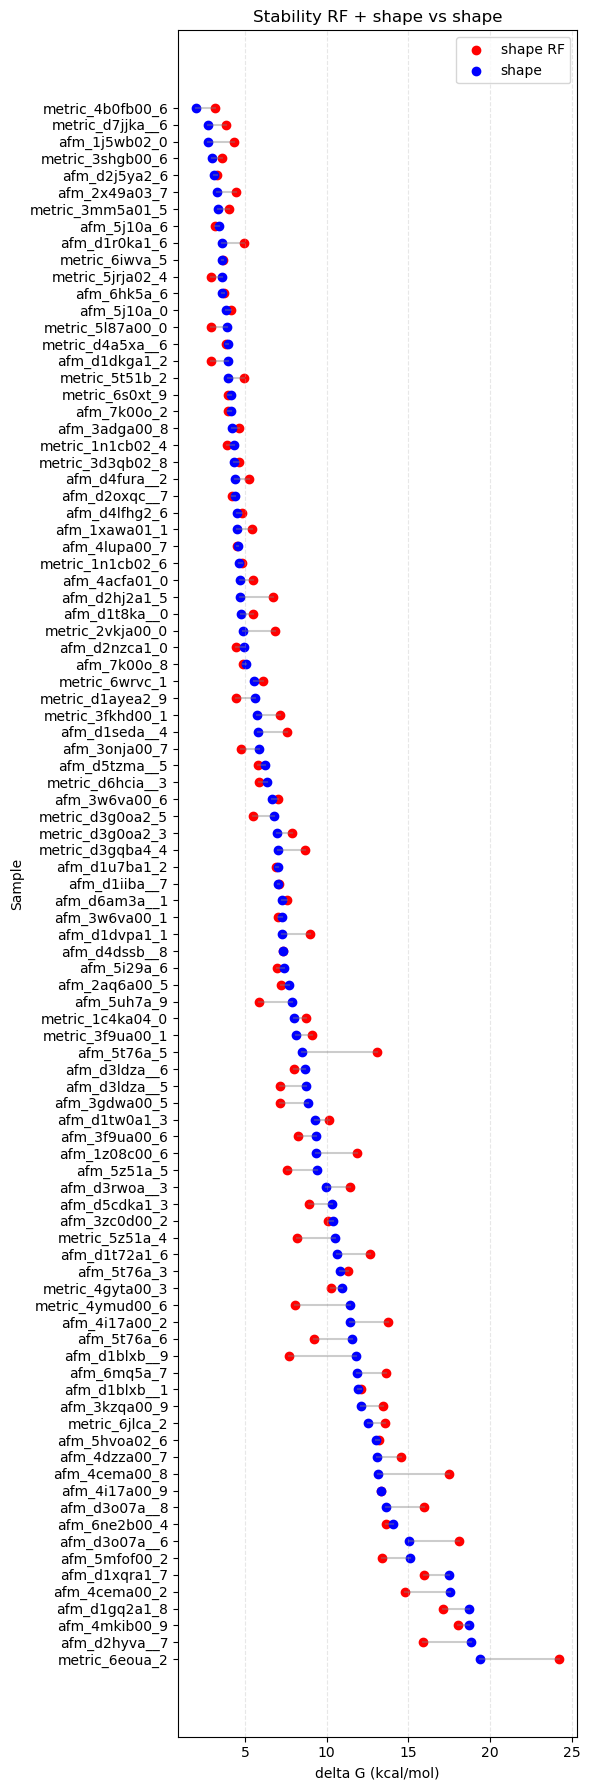

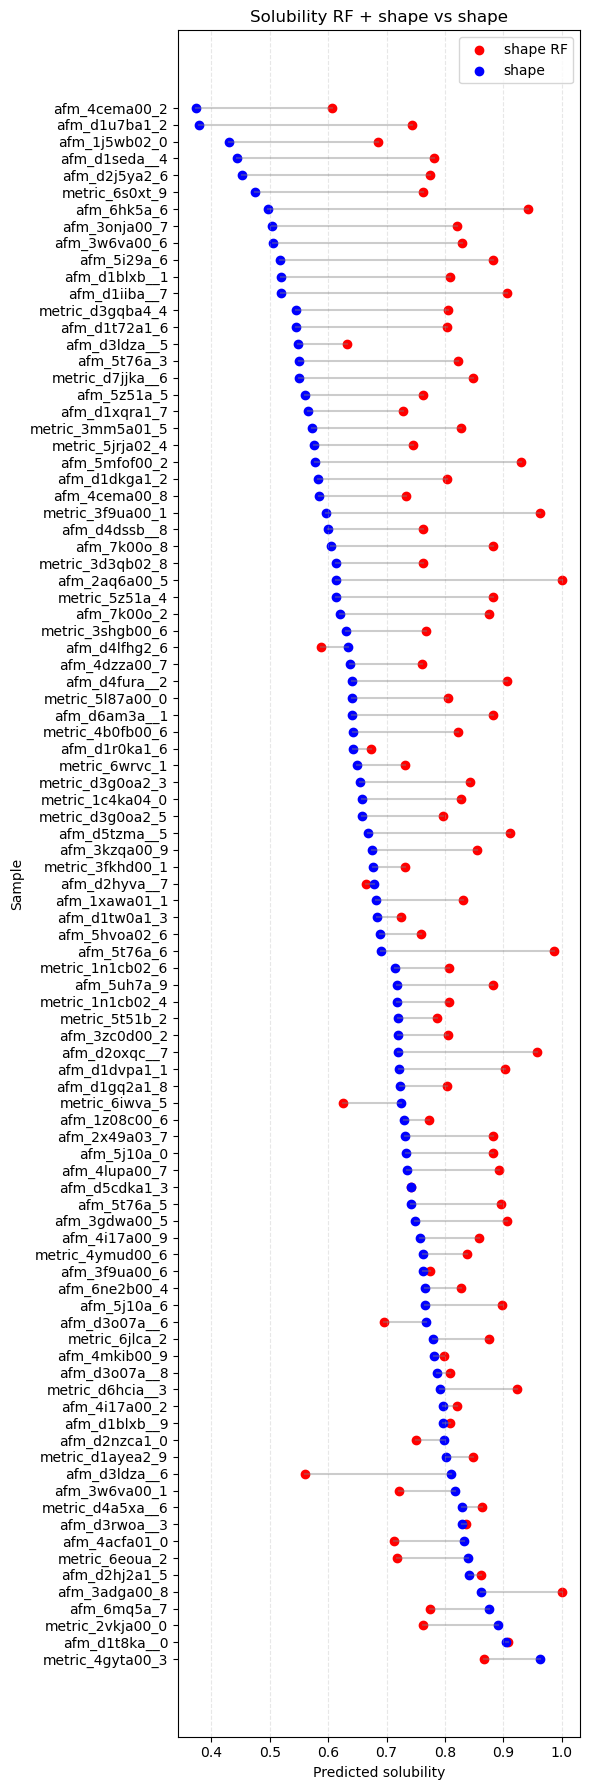

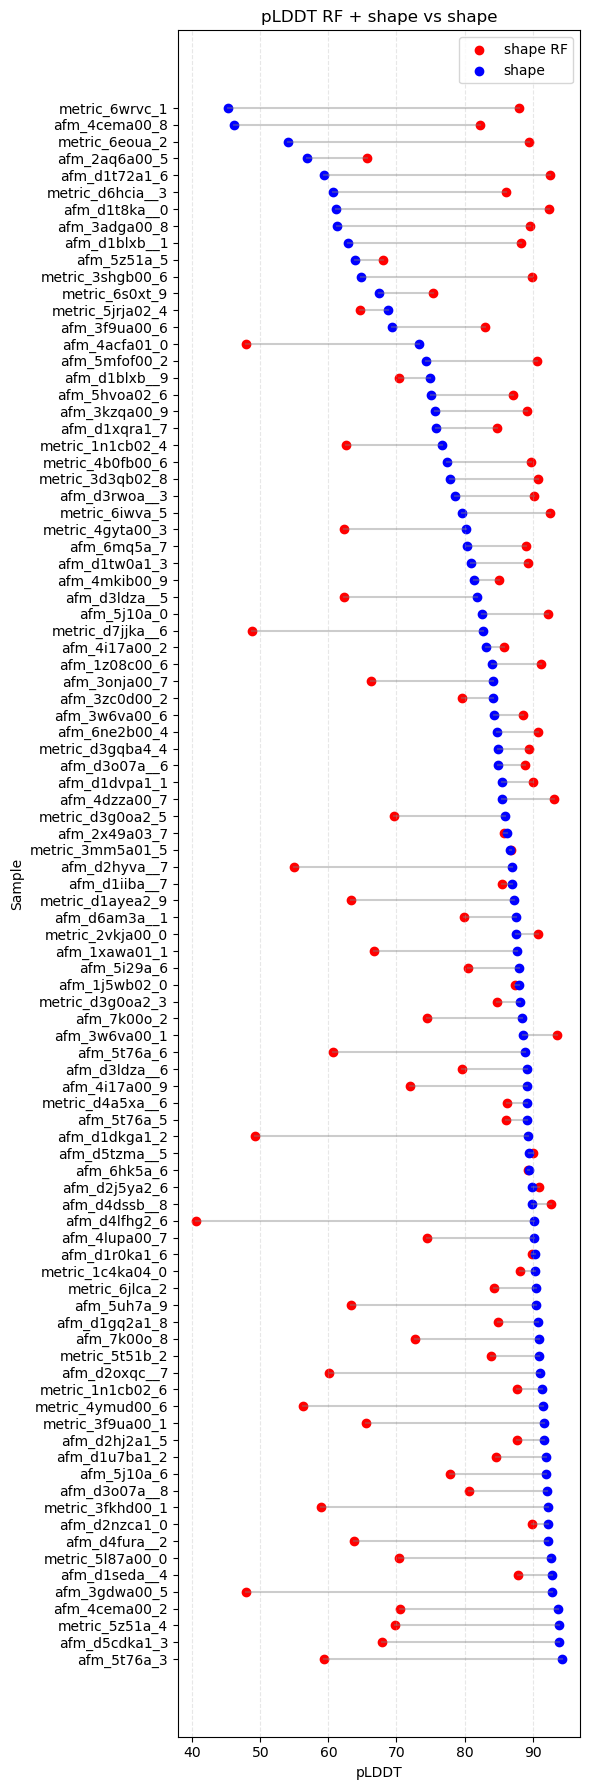

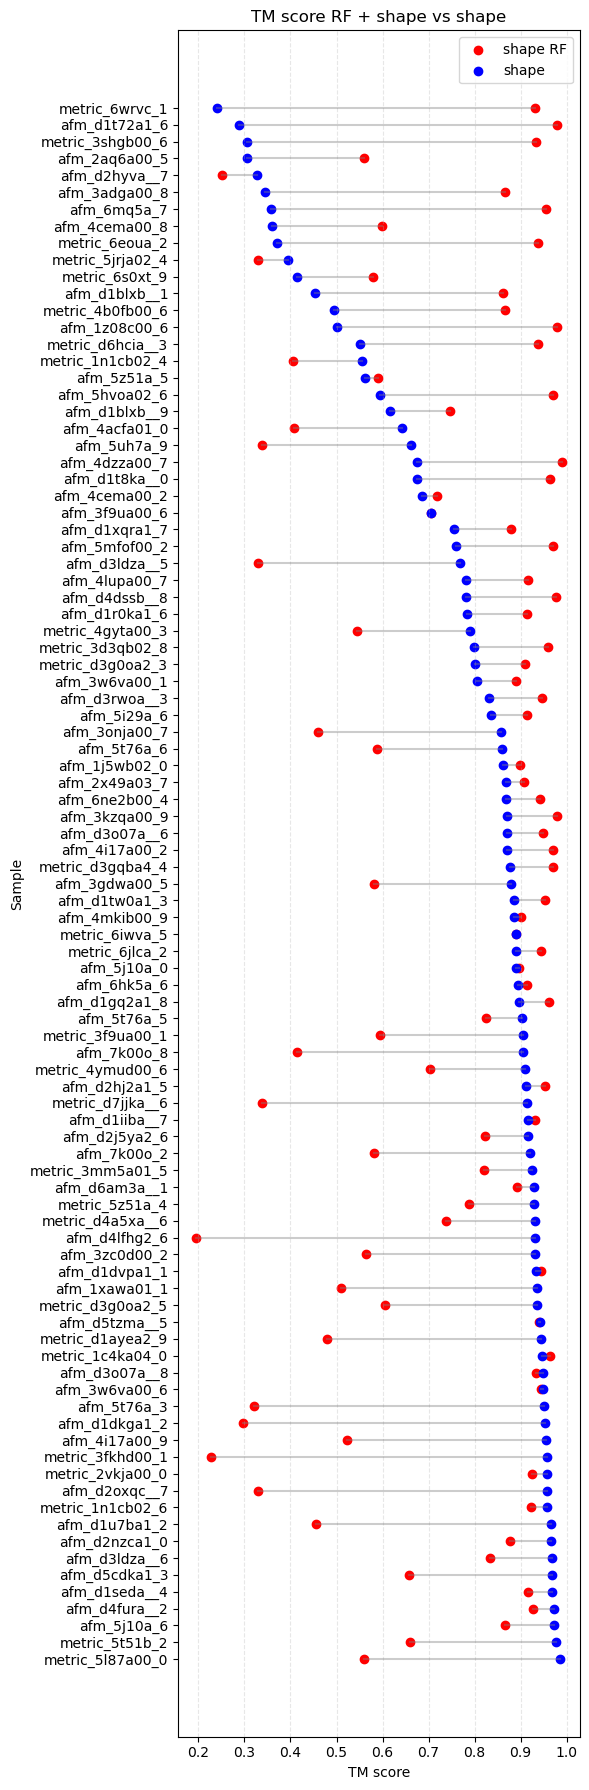

In [17]:
plot_df = pd.DataFrame({
    'file_ID': RF_shapedesign_df['file_ID'],
    'stab_RF_shape': RF_shapedesign_df['stab_w'],
    'stab_shape': RF_shapedesign_df['stab_wo'] ,
    'hydro_RF_shape' : RF_shapedesign_df['hydrophob_w'] ,
    'hydro_shape' : RF_shapedesign_df['hydrophob_wo'] ,
    'sol_RF_shape' : RF_shapedesign_df['solubility_w'] ,
    'sol_shape' : RF_shapedesign_df['solubility_wo'],
    'pLDDT_RF_shape' : RF_shapedesign_df['pLDDT_w'],
    'pLDDT_shape' : RF_shapedesign_df['pLDDT_wo'],
    'RMSD_RF_shape': RF_shapedesign_df['RMSD_pred-ex_w'],
    'RMSD_shape': RF_shapedesign_df['RMSD_pred-ex_wo'],
    'tm_RF_shape' : RF_shapedesign_df['Tm_pred-ex_w'],
    'tm_shape' : RF_shapedesign_df['Tm_pred-ex_wo']
})
plot_paired(plot_df,"stab_RF_shape","stab_shape","Stability RF + shape vs shape","delta G (kcal/mol)","shape RF","shape","stab_shape",size = (6,18))
plot_paired(plot_df,"sol_RF_shape","sol_shape","Solubility RF + shape vs shape","Predicted solubility","shape RF","shape","sol_shape",size = (6,18))
plot_paired(plot_df,"pLDDT_RF_shape","pLDDT_shape","pLDDT RF + shape vs shape","pLDDT","shape RF","shape","pLDDT_shape",size = (6,18))
plot_paired(plot_df,"tm_RF_shape","tm_shape","TM score RF + shape vs shape","TM score","shape RF","shape","tm_shape",size = (6,18))

/tmp/ipykernel_1021655/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1021655/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


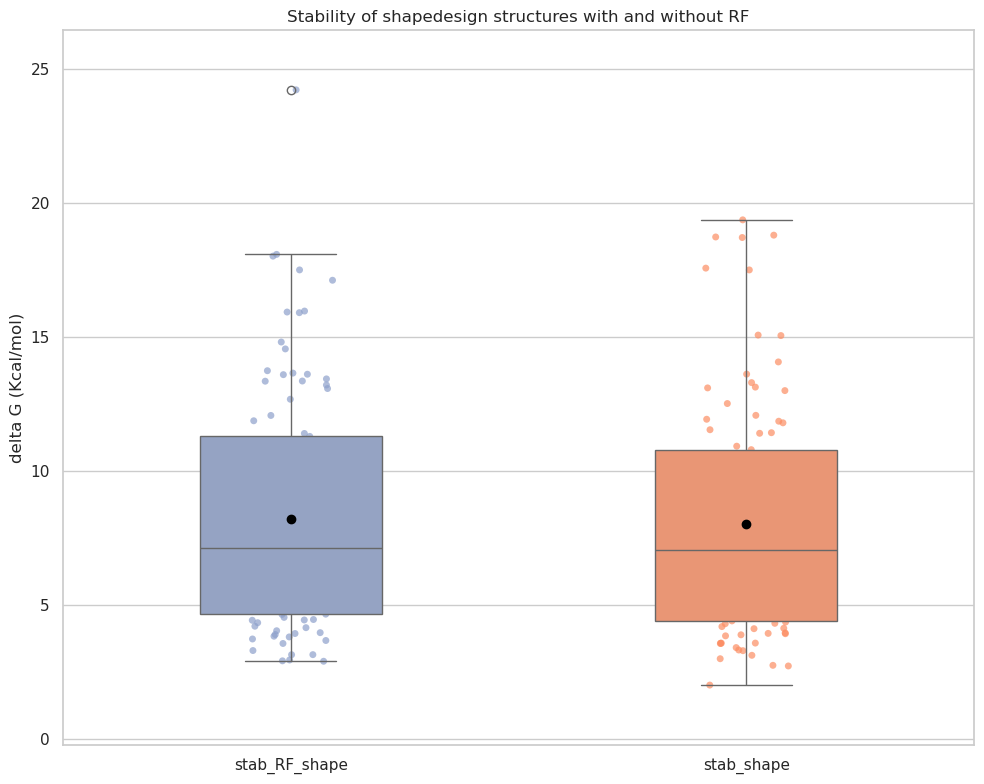

In [7]:
pLDDT_palette = {
    "stab_shape": "#fc8d62",   # soft orange
    "stab_RF_shape": "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["stab_RF_shape","stab_shape"],"delta G (Kcal/mol)",pLDDT_palette,"Stability of shapedesign structures with and without RF","delta G (Kcal/mol)",(10,8))


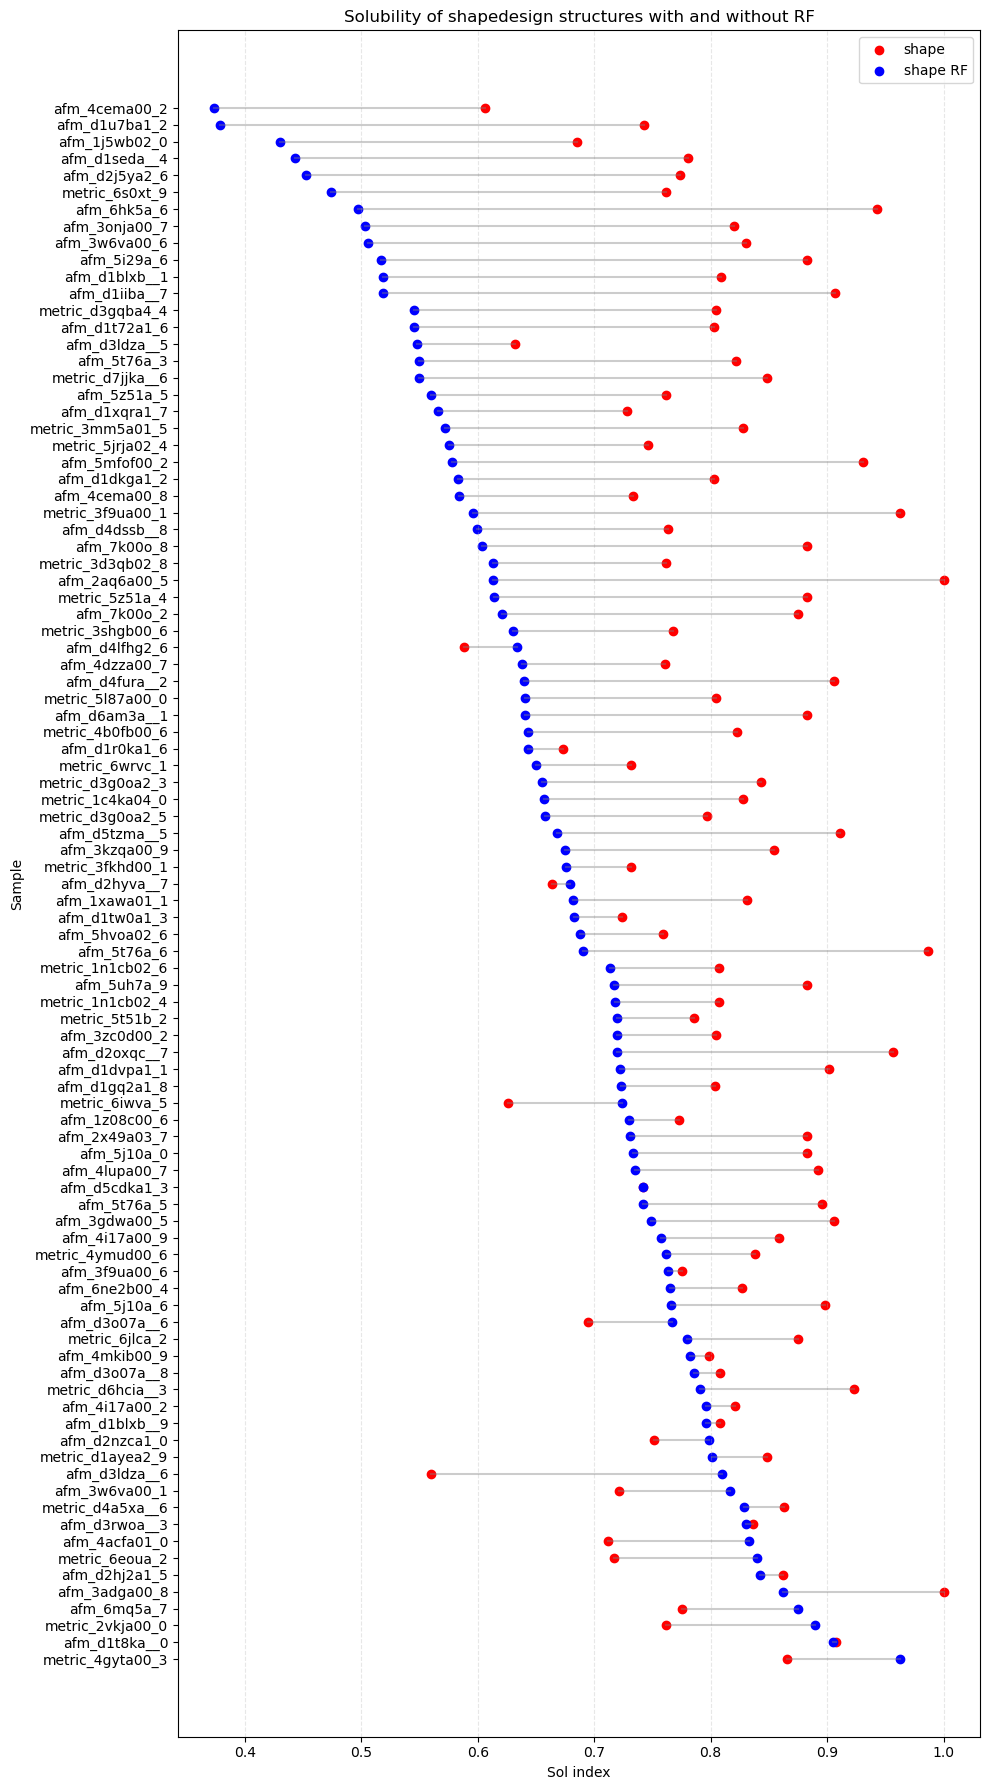

In [7]:
# Solubility #####################################################
plot_paired(plot_df,"sol_RF_shape","sol_shape","Solubility of shapedesign structures with and without RF","Sol index","shape","shape RF","sol_shape")


/tmp/ipykernel_1021655/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1021655/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


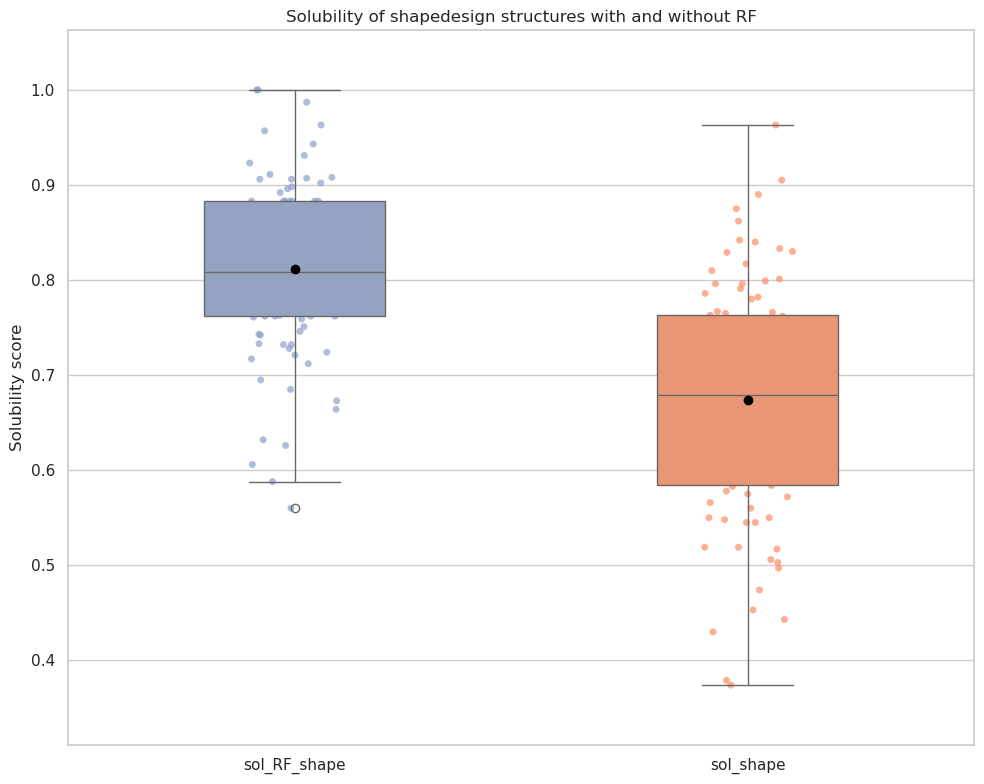

In [8]:
pLDDT_palette = {
    "sol_shape": "#fc8d62",   # soft orange
    "sol_RF_shape": "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["sol_RF_shape","sol_shape"],"Solubility score",pLDDT_palette,"Solubility of shapedesign structures with and without RF","Solubility score",(10,8))


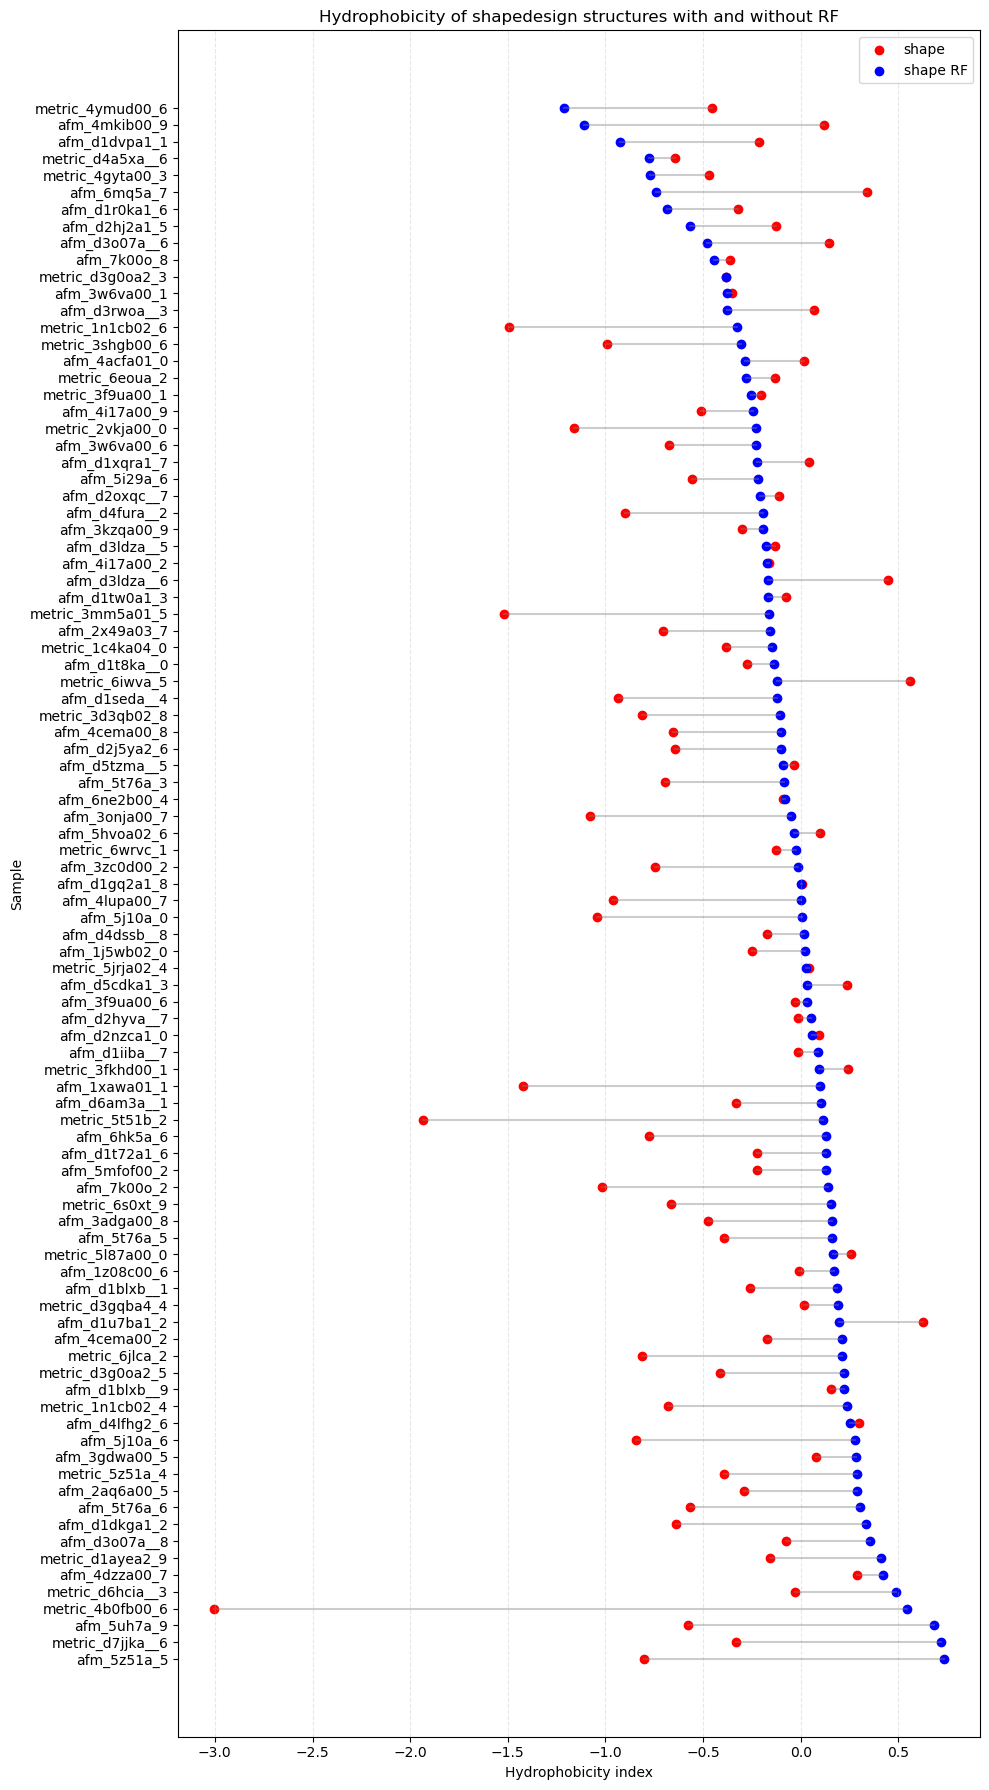

In [8]:
# Hydrophobicity #################################################
plot_paired(plot_df,"hydro_RF_shape","hydro_shape","Hydrophobicity of shapedesign structures with and without RF","Hydrophobicity index","shape","shape RF","hydro_shape")


/tmp/ipykernel_1021655/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1021655/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


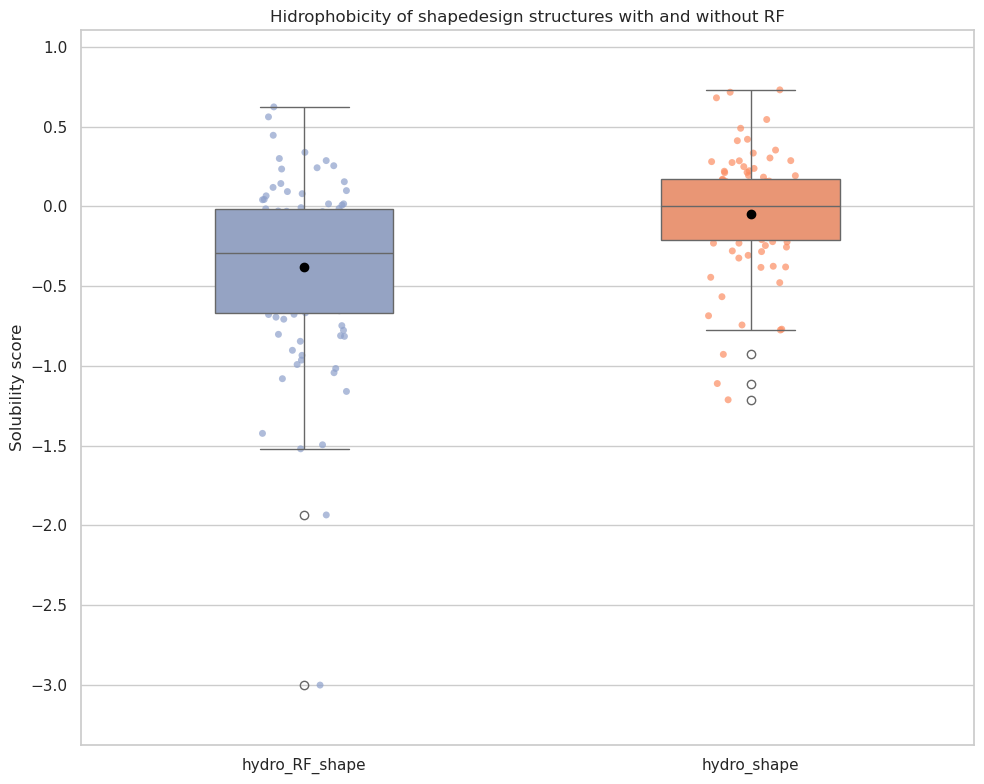

In [10]:
pLDDT_palette = {
    "hydro_shape": "#fc8d62",   # soft orange
    "hydro_RF_shape": "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["hydro_RF_shape","hydro_shape"],"Solubility score",pLDDT_palette,"Hidrophobicity of shapedesign structures with and without RF","Solubility score",(10,8))


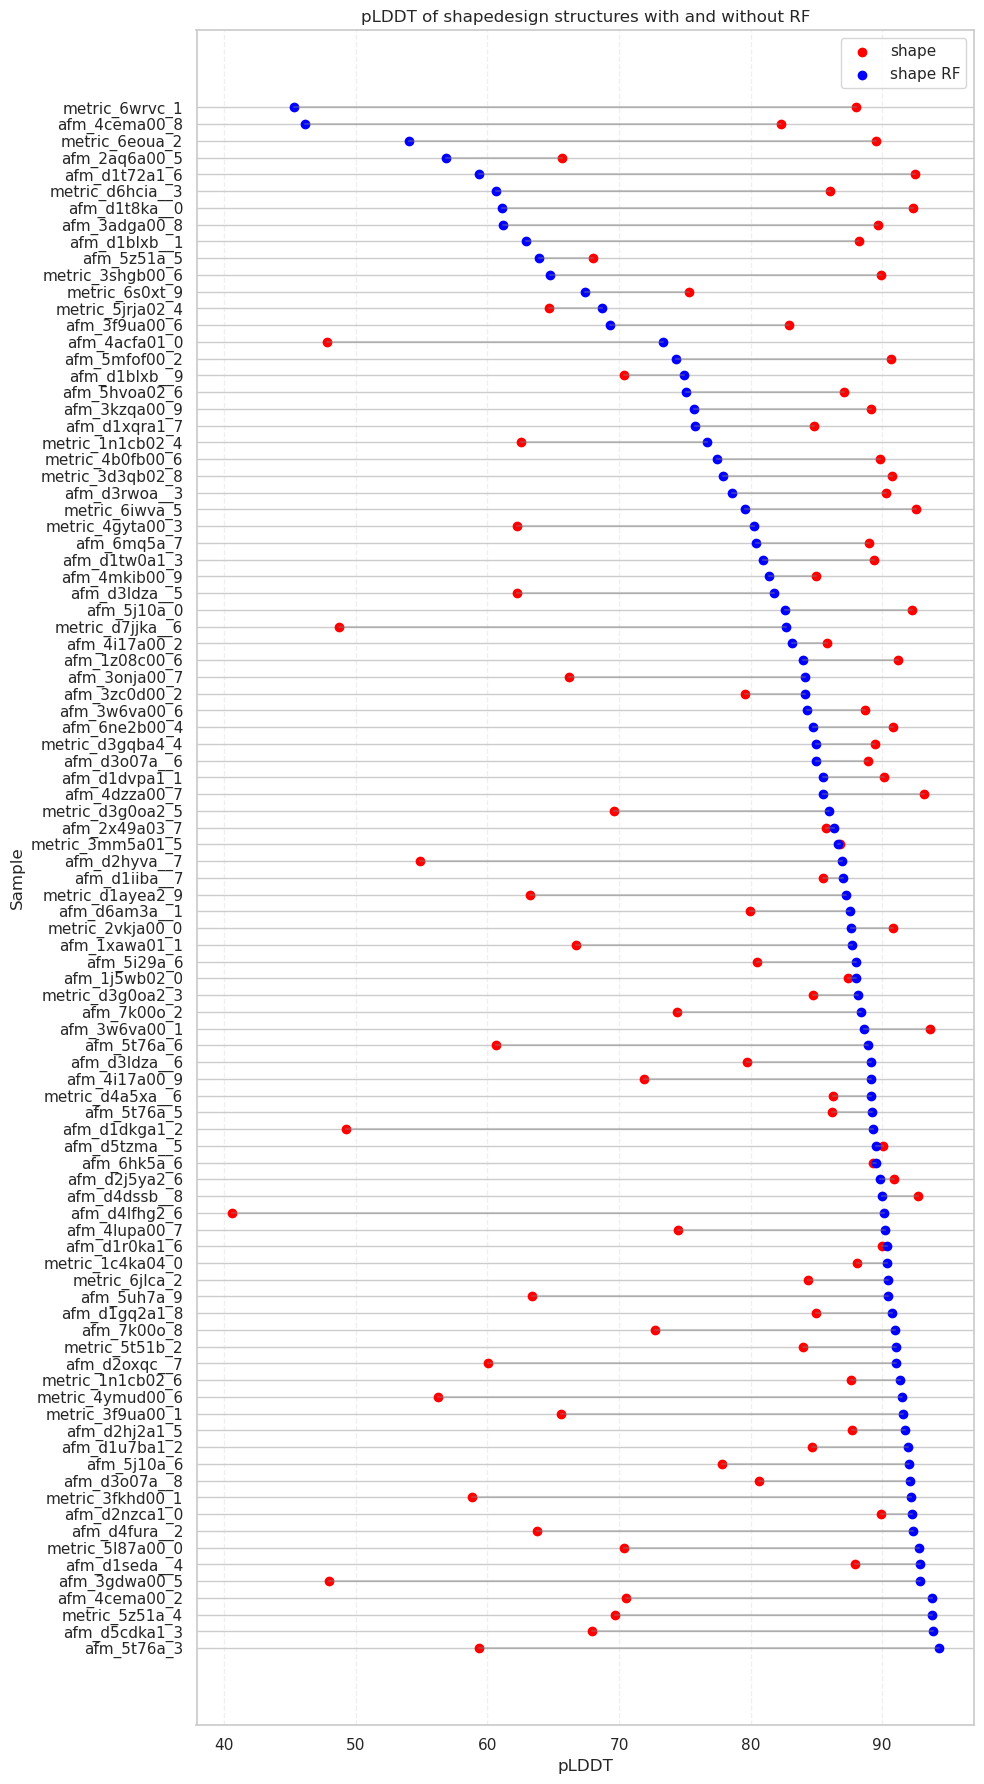

In [12]:
# pLDDT ##########################################################
plot_paired(plot_df,"pLDDT_RF_shape","pLDDT_shape","pLDDT of shapedesign structures with and without RF","pLDDT","shape","shape RF","pLDDT_shape")


/tmp/ipykernel_1021655/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1021655/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


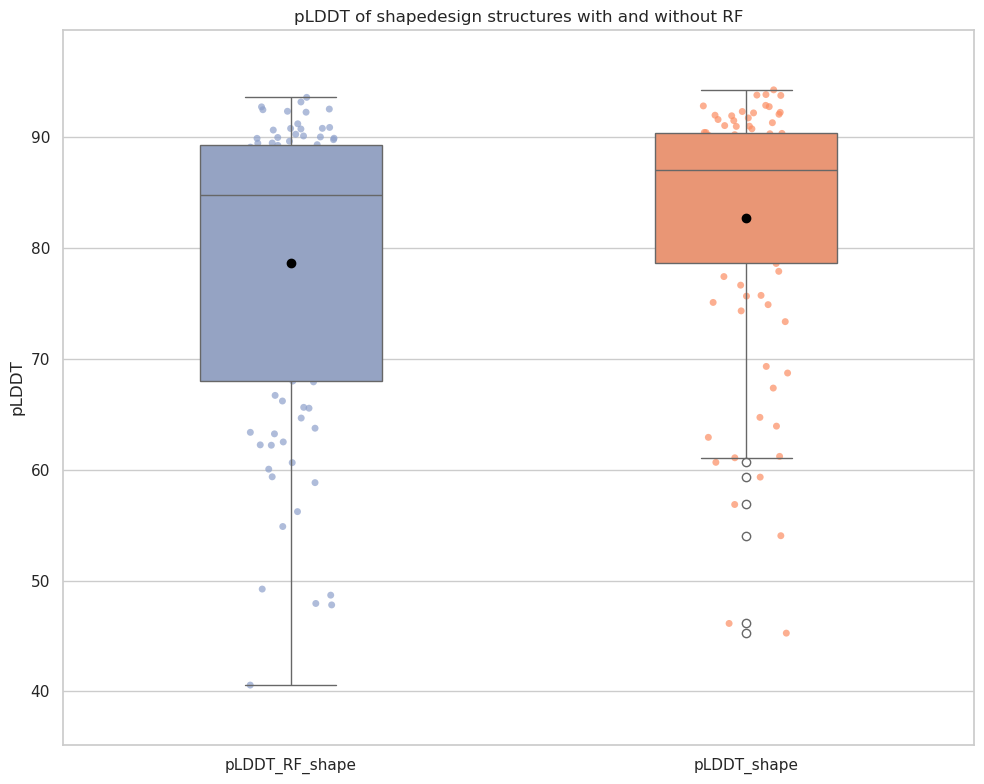

In [13]:
pLDDT_palette = {
    "pLDDT_shape": "#fc8d62",   # soft orange
    "pLDDT_RF_shape": "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["pLDDT_RF_shape","pLDDT_shape"],"pLDDT",pLDDT_palette,"pLDDT of shapedesign structures with and without RF","pLDDT",(10,8))


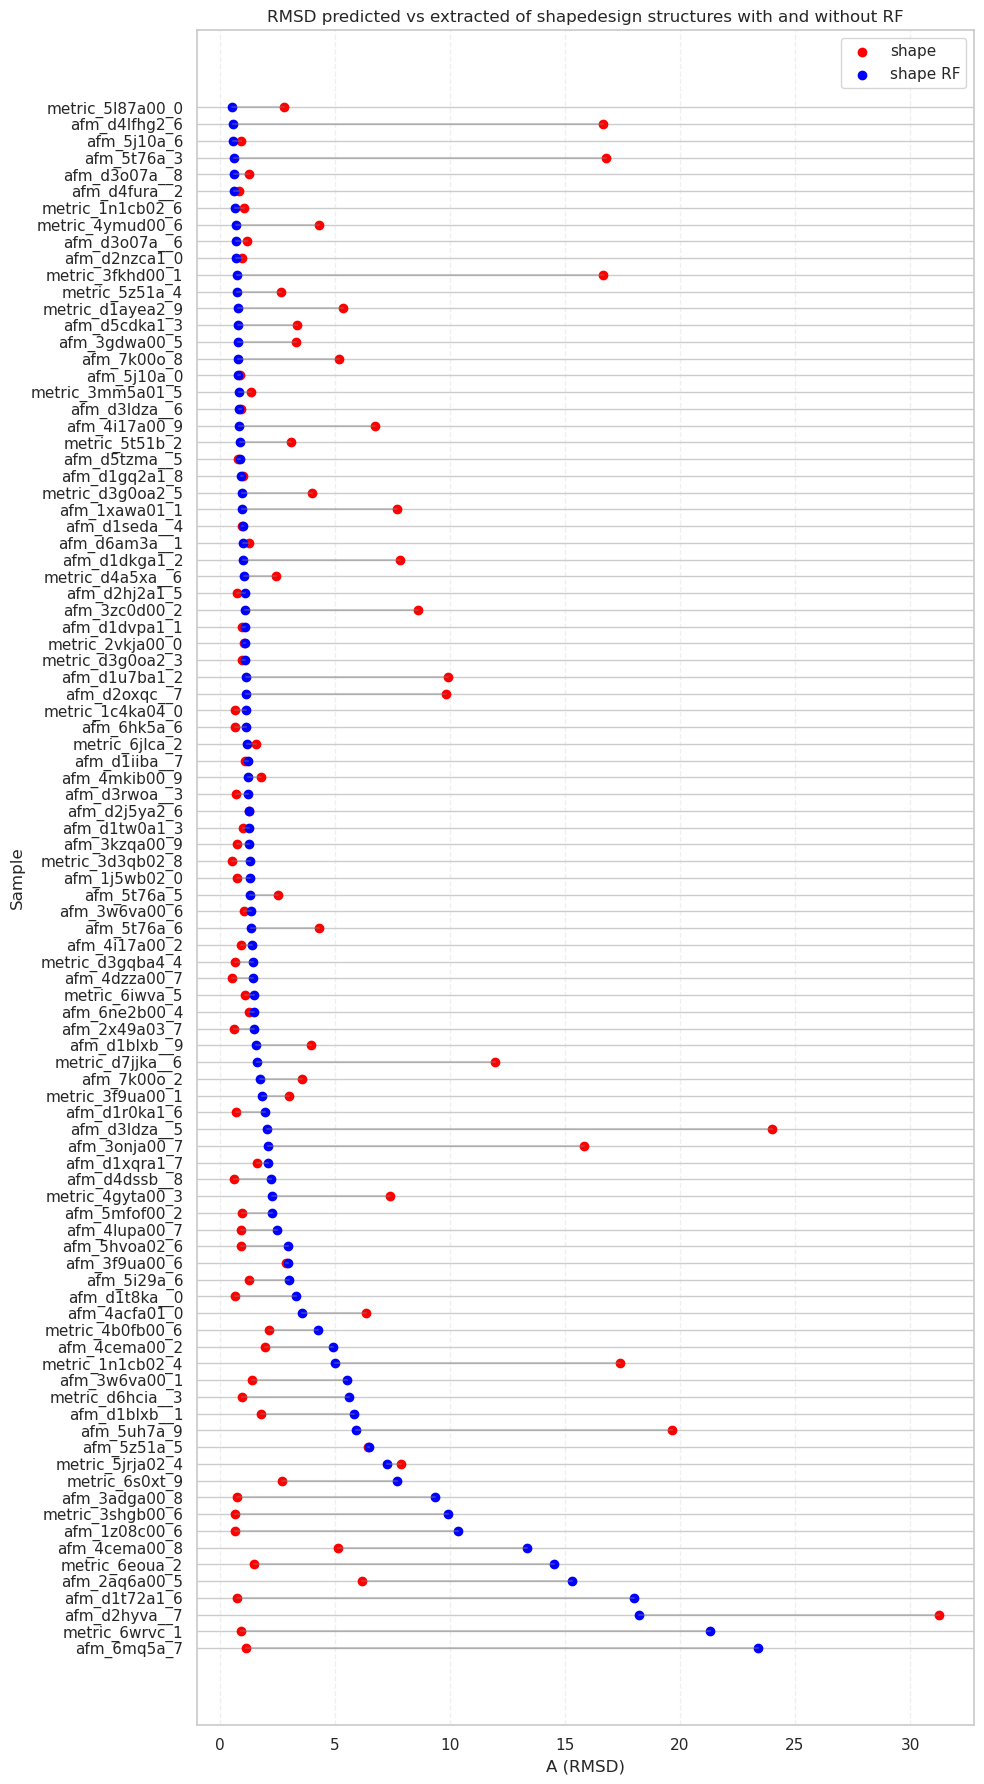

In [14]:
# RMSD ##########################################################
plot_paired(plot_df,"RMSD_pred_RF_shape","RMSD_pred_shape","RMSD predicted vs extracted of shapedesign structures with and without RF","A (RMSD)","shape","shape RF","RMSD_pred_shape")


/tmp/ipykernel_1021655/942138497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1021655/942138497.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


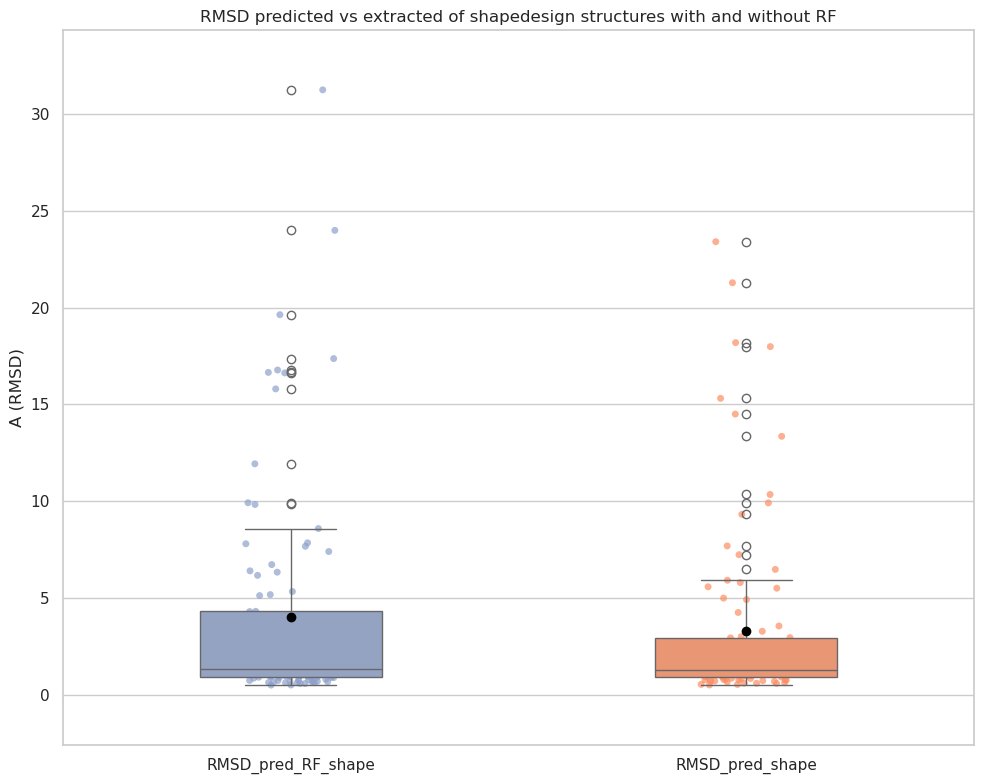

In [15]:
pLDDT_palette = {
    "RMSD_pred_shape": "#fc8d62",   # soft orange
    "RMSD_pred_RF_shape": "#8da0cb"   # lavender-blue
    }
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(plot_df,["RMSD_pred_RF_shape","RMSD_pred_shape"],"A (RMSD)",pLDDT_palette,"RMSD predicted vs extracted of shapedesign structures with and without RF","A (RMSD)",(10,8))


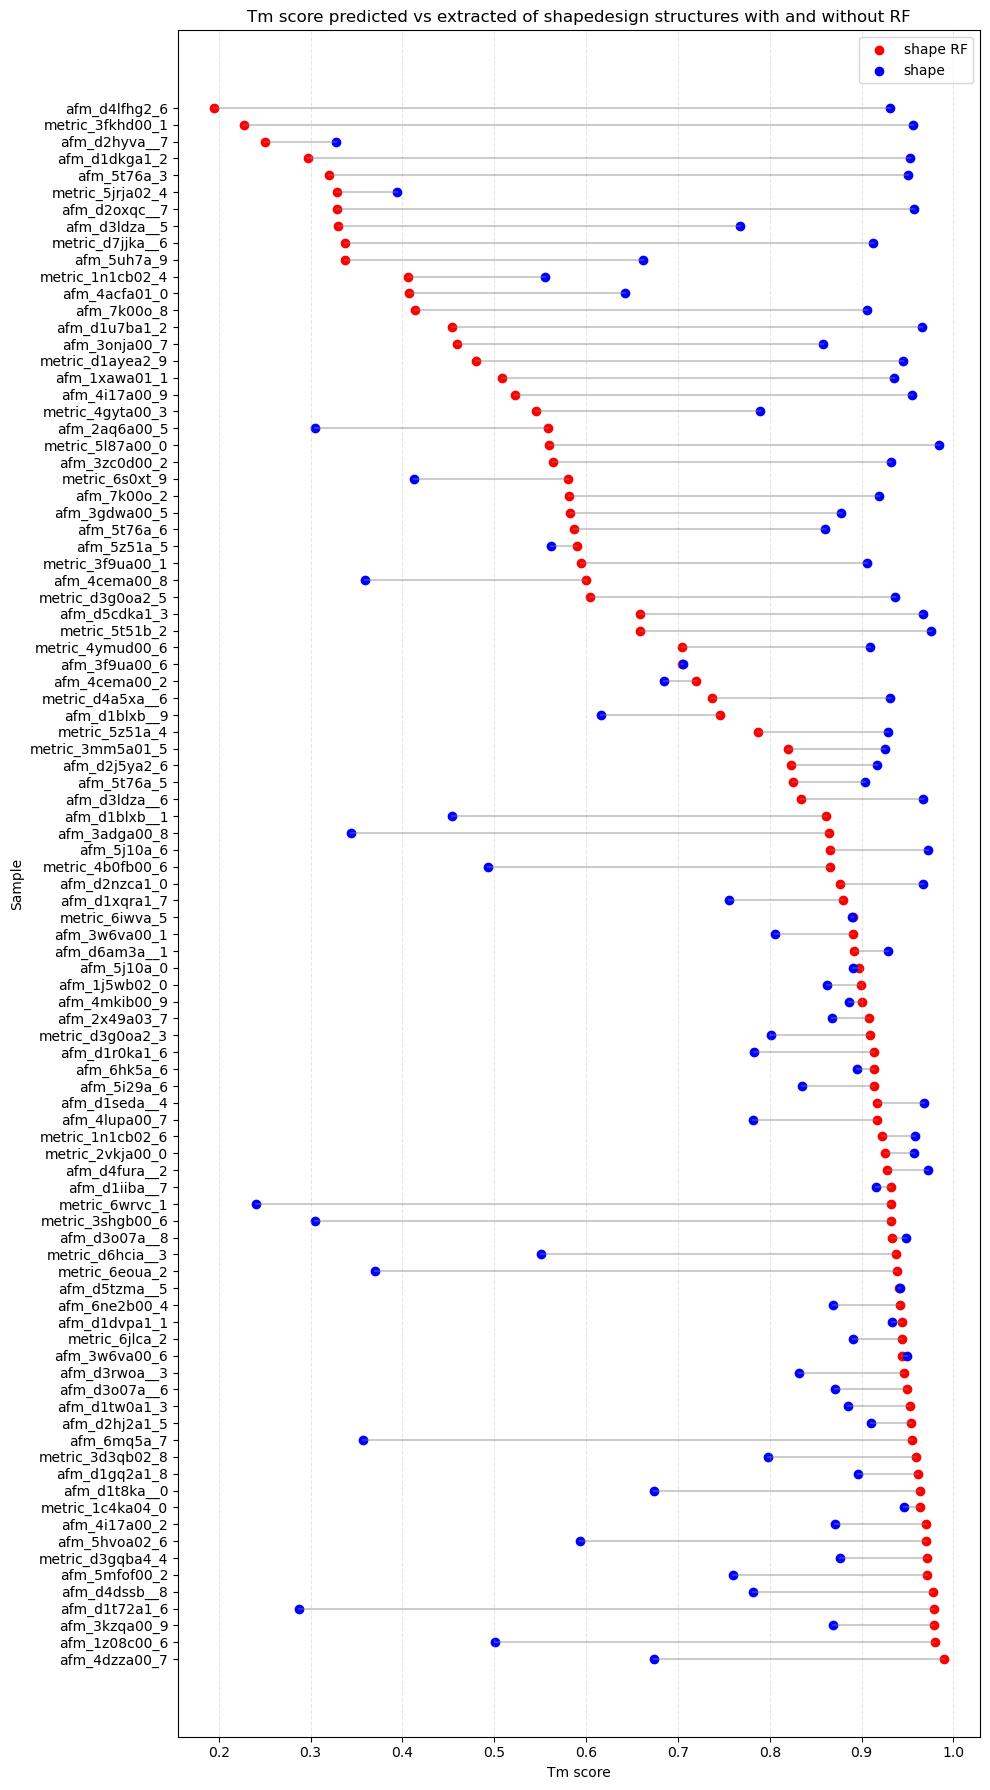

In [9]:
# TM score ######################################################
plot_paired(plot_df,"tm_RF_shape","tm_shape","Tm score predicted vs extracted of shapedesign structures with and without RF","Tm score","shape RF","shape","tm_RF_shape")

In [15]:
# Stats ##########################################################

# Is the increase in stability significantly different?
# Is the solubility significantly different?
# Is the hydrophobicity significantly different?
# Is the plddt significantly different ?
# Is the TM score significantly different ?
stats_A_stab = statistics_columns(plot_df,'stab_shape','stab_RF_shape', paired = True)
stats_A_hydro = statistics_columns(plot_df,'hydro_shape','hydro_RF_shape', paired = True)
stats_A_sol = statistics_columns(plot_df,'sol_shape','sol_RF_shape', paired = True)
stats_A_plddt = statistics_columns(plot_df,'pLDDT_shape','pLDDT_RF_shape', paired = True, treshold=80)
stats_A_tm = statistics_columns(plot_df,'tm_shape','tm_RF_shape', paired = True, treshold = 0.4)

In [23]:
print(stats_A_stab )
print(stats_A_hydro)
print(stats_A_sol )
print(stats_A_plddt)
print(stats_A_tm )

{'test': 'Wilcoxon signed-rank', 'p_value': 0.24177898780409346, 'star': 'ns', 'statistic': 1880.0, 'mean stab_shape': 8.027766899563073, 'mean stab_RF_shape': 8.216416866101003, 'over_treshold stab_shape': 93, 'over_treshold stab_RF_shape': 93, 'times stab_shape > stab_RF_shape': 42, 'times stab_RF_shape > stab_shape': 51, 'mean_difference': -0.18864996653793042, 'effect_size': -0.09677419354838707, 'normality': {'col1': 1.066739856746896e-05, 'col2': 1.686351927311299e-06}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 1.24285078042709e-05, 'star': '***', 'statistic': 1045.0, 'mean hydro_shape': -0.04413449362003458, 'mean hydro_RF_shape': -0.3789915102496512, 'over_treshold hydro_shape': 46, 'over_treshold hydro_RF_shape': 21, 'times hydro_shape > hydro_RF_shape': 60, 'times hydro_RF_shape > hydro_shape': 33, 'mean_difference': 0.33485701662961664, 'effect_size': 0.29032258064516125, 'normality': {'col1': 0.0026884816902516136, 'col2': 6.3900773268634435e-06}, 

In [18]:
# RF + shape vs RF
B_df = pd.DataFrame({
    "stab_w" : RF_shapedesign_df["stab_w"],
    "stab_wo" : only_RF_df["delta_G"],
    "hydro_w" : RF_shapedesign_df["hydrophob_w"],
    "hydro_wo" : only_RF_df["hydro_RF"],
    "sol_w" : RF_shapedesign_df["solubility_w"],
    "sol_wo" : only_RF_df["sol_RF"]
})
stats_B_stab = statistics_columns(B_df,'stab_wo','stab_w', paired = True)
stats_B_hydro = statistics_columns(B_df,'hydro_wo','hydro_w', paired = True)
stats_B_sol = statistics_columns(B_df,'sol_wo','sol_w', paired = True)
print (stats_B_stab)
print (stats_B_hydro)
print (stats_B_sol)

{'test': 'Wilcoxon signed-rank', 'p_value': 0.057120693850764764, 'star': 'ns', 'statistic': 1689.0, 'mean stab_wo': 9.804959964377328, 'mean stab_w': 8.216416866101005, 'over_treshold stab_wo': 93, 'over_treshold stab_w': 93, 'times stab_wo > stab_w': 55, 'times stab_w > stab_wo': 38, 'mean_difference': 1.5885430982763236, 'effect_size': 0.1827956989247312, 'normality': {'col1': 6.262272027297715e-05, 'col2': 1.6863519273112616e-06}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 9.708109707960177e-06, 'star': '***', 'statistic': 1031.0, 'mean hydro_wo': -0.756097397927718, 'mean hydro_w': -0.3789915102496512, 'over_treshold hydro_wo': 5, 'over_treshold hydro_w': 21, 'times hydro_wo > hydro_w': 24, 'times hydro_w > hydro_wo': 69, 'mean_difference': -0.3771058876780668, 'effect_size': -0.4838709677419355, 'normality': {'col1': 0.0019116718164362086, 'col2': 6.3900773268634435e-06}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 7.73766724182220

In [19]:
# shape only vs RF only
C_df = pd.DataFrame({
    "stab_w" : RF_shapedesign_df["stab_wo"],
    "stab_wo" : only_RF_df["delta_G"],
    "hydro_w" : RF_shapedesign_df["hydrophob_wo"],
    "hydro_wo" : only_RF_df["hydro_RF"],
    "sol_w" : RF_shapedesign_df["solubility_wo"] ,
    "sol_wo" : only_RF_df["sol_RF"]
})
stats_C_stab = statistics_columns(C_df,'stab_wo','stab_w', paired = True)
stats_C_hydro = statistics_columns(C_df,'hydro_wo','hydro_w', paired = True)
stats_C_sol = statistics_columns(C_df,'sol_wo','sol_w', paired = True)
print (stats_C_stab)
print (stats_C_hydro)
print (stats_C_sol)

{'test': 'Wilcoxon signed-rank', 'p_value': 0.038720526892842326, 'star': '*', 'statistic': 1646.0, 'mean stab_wo': 9.804959964377328, 'mean stab_w': 8.027766899563076, 'over_treshold stab_wo': 93, 'over_treshold stab_w': 93, 'times stab_wo > stab_w': 54, 'times stab_w > stab_wo': 39, 'mean_difference': 1.7771930648142522, 'effect_size': 0.16129032258064518, 'normality': {'col1': 6.262272027297715e-05, 'col2': 1.066739856746938e-05}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 8.572903782190092e-13, 'star': '***', 'statistic': 319.0, 'mean hydro_wo': -0.756097397927718, 'mean hydro_w': -0.044134493620034555, 'over_treshold hydro_wo': 5, 'over_treshold hydro_w': 46, 'times hydro_wo > hydro_w': 11, 'times hydro_w > hydro_wo': 82, 'mean_difference': -0.7119629043076835, 'effect_size': -0.7634408602150538, 'normality': {'col1': 0.0019116718164362086, 'col2': 0.0026884816902515065}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 2.992878148238115

In [20]:
# RF + shape vs original
D_df = pd.DataFrame({
    "stab_w" : RF_shapedesign_df["stab_w"],
    "stab_wo" : original_df["delta_G"],
    "hydro_w" : RF_shapedesign_df["hydrophob_w"],
    "hydro_wo" : original_df["hydro_orig"],
    "sol_w" : RF_shapedesign_df["solubility_w"] ,
    "sol_wo" : original_df["sol_orig"]
})
stats_D_stab = statistics_columns(D_df,'stab_wo','stab_w', paired = True)
stats_D_hydro = statistics_columns(D_df,'hydro_wo','hydro_w', paired = True)
stats_D_sol = statistics_columns(D_df,'sol_wo','sol_w', paired = True)
print (stats_D_stab)
print (stats_D_hydro)
print (stats_D_sol)

{'test': 'Wilcoxon signed-rank', 'p_value': 0.002052580818000042, 'star': '**', 'statistic': 1381.0, 'mean stab_wo': 6.415102013319124, 'mean stab_w': 8.216416866101005, 'over_treshold stab_wo': 93, 'over_treshold stab_w': 93, 'times stab_wo > stab_w': 39, 'times stab_w > stab_wo': 52, 'mean_difference': -1.8013148527818812, 'effect_size': -0.26881720430107525, 'normality': {'col1': 2.6688962042865197e-06, 'col2': 1.6863519273112616e-06}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 8.652076554694366e-11, 'star': '***', 'statistic': 492.0, 'mean hydro_wo': 0.2000209528501978, 'mean hydro_w': -0.3789915102496512, 'over_treshold hydro_wo': 67, 'over_treshold hydro_w': 21, 'times hydro_wo > hydro_w': 74, 'times hydro_w > hydro_wo': 17, 'mean_difference': 0.579012463099849, 'effect_size': 0.4838709677419355, 'normality': {'col1': 4.412982605112644e-06, 'col2': 6.3900773268634435e-06}, 'equal_variance': None}
{'test': 'Paired t-test', 'p_value': 9.22208548322742e-29, 

In [21]:
# RF ONLY VS ORIGINAL
E_df = pd.DataFrame({
    "stab_w" : only_RF_df["delta_G"],
    "stab_wo" : original_df["delta_G"],
    "hydro_w" : only_RF_df["hydro_RF"],
    "hydro_wo" : original_df["hydro_orig"],
    "sol_w" : only_RF_df["sol_RF"] ,
    "sol_wo" : original_df["sol_orig"]
})
stats_E_stab = statistics_columns(E_df,'stab_wo','stab_w', paired = True)
stats_E_hydro = statistics_columns(E_df,'hydro_wo','hydro_w', paired = True)
stats_E_sol = statistics_columns(E_df,'sol_wo','sol_w', paired = True)
print (stats_E_stab)
print (stats_E_hydro)
print (stats_E_sol)

{'test': 'Wilcoxon signed-rank', 'p_value': 1.6880785875309786e-06, 'star': '***', 'statistic': 936.0, 'mean stab_wo': 6.415102013319124, 'mean stab_w': 9.804959964377328, 'over_treshold stab_wo': 93, 'over_treshold stab_w': 93, 'times stab_wo > stab_w': 18, 'times stab_w > stab_wo': 73, 'mean_difference': -3.3898579510582048, 'effect_size': -0.4838709677419355, 'normality': {'col1': 2.6688962042865197e-06, 'col2': 6.262272027297715e-05}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 6.332428354955124e-16, 'star': '***', 'statistic': 76.0, 'mean hydro_wo': 0.2000209528501978, 'mean hydro_w': -0.756097397927718, 'over_treshold hydro_wo': 67, 'over_treshold hydro_w': 5, 'times hydro_wo > hydro_w': 88, 'times hydro_w > hydro_wo': 3, 'mean_difference': 0.9561183507779158, 'effect_size': 0.8709677419354838, 'normality': {'col1': 4.412982605112644e-06, 'col2': 0.0019116718164362086}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 1.2508768399114383e

In [22]:
# sHAPE ONLY VS ORIGINAL
F_df = pd.DataFrame({
    "stab_w" : RF_shapedesign_df["stab_wo"],
    "stab_wo" : original_df["delta_G"],
    "hydro_w" : RF_shapedesign_df["hydrophob_wo"],
    "hydro_wo" : original_df["hydro_orig"],
    "sol_w" : RF_shapedesign_df["solubility_wo"],
    "sol_wo" : original_df["sol_orig"]
})
stats_F_stab = statistics_columns(F_df,'stab_wo','stab_w', paired = True)
stats_F_hydro = statistics_columns(F_df,'hydro_wo','hydro_w', paired = True)
stats_F_sol = statistics_columns(F_df,'sol_wo','sol_w', paired = True)
print (stats_F_stab)
print (stats_F_hydro)
print (stats_F_sol)

{'test': 'Wilcoxon signed-rank', 'p_value': 0.007191094310669439, 'star': '**', 'statistic': 1484.0, 'mean stab_wo': 6.415102013319124, 'mean stab_w': 8.027766899563076, 'over_treshold stab_wo': 93, 'over_treshold stab_w': 93, 'times stab_wo > stab_w': 41, 'times stab_w > stab_wo': 50, 'mean_difference': -1.6126648862439525, 'effect_size': -0.20430107526881724, 'normality': {'col1': 2.6688962042865197e-06, 'col2': 1.066739856746938e-05}, 'equal_variance': None}
{'test': 'Wilcoxon signed-rank', 'p_value': 9.827383095318054e-05, 'star': '***', 'statistic': 1169.0, 'mean hydro_wo': 0.2000209528501978, 'mean hydro_w': -0.044134493620034555, 'over_treshold hydro_wo': 67, 'over_treshold hydro_w': 46, 'times hydro_wo > hydro_w': 64, 'times hydro_w > hydro_wo': 27, 'mean_difference': 0.24415544647023235, 'effect_size': 0.3548387096774193, 'normality': {'col1': 4.412982605112644e-06, 'col2': 0.0026884816902515065}, 'equal_variance': None}
{'test': 'Paired t-test', 'p_value': 4.755209549591801e-

/tmp/ipykernel_1334972/3210474050.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1334972/3210474050.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


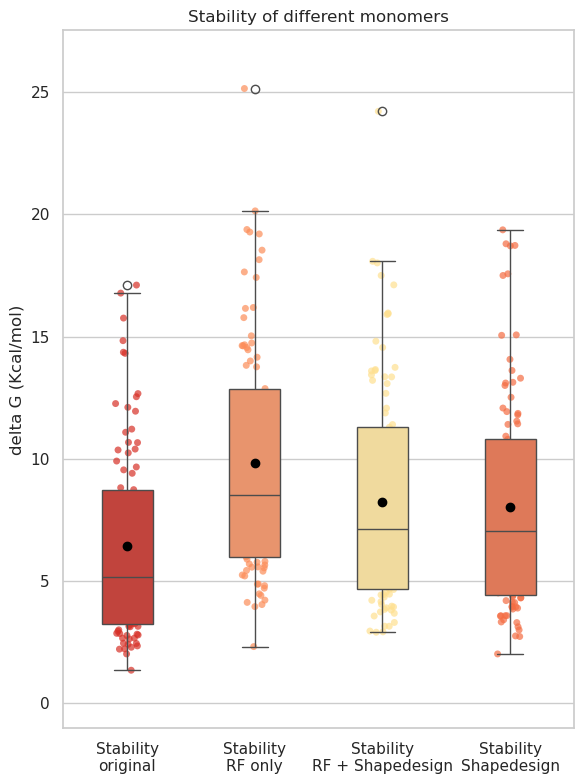

/tmp/ipykernel_1334972/3210474050.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_1334972/3210474050.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


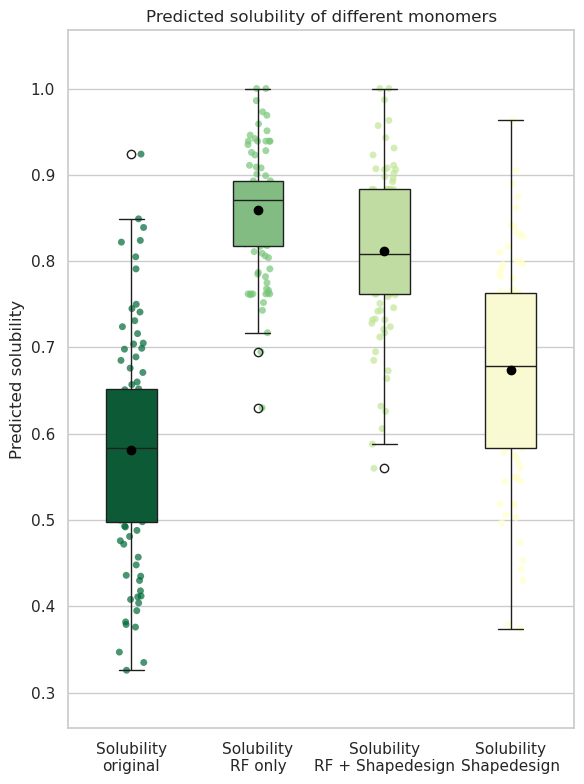

In [19]:
monomer_boxplot_df = pd.DataFrame({
    "Stability\noriginal" : original_df["delta_G"],
    "Stability\nRF only" : only_RF_df["delta_G"],
    "Stability\nRF + Shapedesign" : RF_shapedesign_df["stab_w"],
    "Stability\nShapedesign" : RF_shapedesign_df["stab_wo"],
    "Solubility\noriginal" : original_df["sol_orig"],
    "Solubility\nRF only" : only_RF_df["sol_RF"],
    "Solubility\nRF + Shapedesign" : RF_shapedesign_df["solubility_w"],
    "Solubility\nShapedesign" : RF_shapedesign_df["solubility_wo"],
    "hello" : "hello"
})
stab_palette = {
    "Stability\noriginal": "#d73027",       # rojo intenso
    "Stability\nRF only": "#fc8d59",        # naranja fuerte
    "Stability\nRF + Shapedesign": "#fee090",  # naranja claro
    "Stability\nShapedesign": "#f46d43"     # rojo-naranja
}

sol_palette = {
    "Solubility\noriginal": "#006837",        # verde oscuro
    "Solubility\nRF only": "#78c679",         # verde medio
    "Solubility\nRF + Shapedesign": "#c2e699",  # verde-amarillo
    "Solubility\nShapedesign": "#ffffcc"      # amarillo claro
}
#boxplot(df,col_list,value,palette,tittle,y_lab,output_name,fig_size):
boxplot(monomer_boxplot_df,["Stability\noriginal","Stability\nRF only","Stability\nRF + Shapedesign","Stability\nShapedesign"],"delta G (Kcal/mol)",stab_palette,"Stability of different monomers","delta G (Kcal/mol)",(6,8))
boxplot(monomer_boxplot_df,["Solubility\noriginal","Solubility\nRF only","Solubility\nRF + Shapedesign",'Solubility\nShapedesign'],"Predicted solubility",sol_palette,"Predicted solubility of different monomers","Predicted solubility",(6,8))

In [3]:
methods_df = pd.read_csv("/home/eduardo/prediction_methods_comparison.csv")
methods_df.head()

Unnamed: 0               file_ID  partial_T  \
0           0  metric_d6hcia__3.pdb         20   
1           1  metric_1c4kA04_0.pdb         20   
2           2     afm_1z08C00_6.pdb         20   
3           3     afm_d1u7ba1_2.pdb         10   
4           4     afm_1z08C00_6.pdb         10   

                                            sequence    af_time  esm_time  \
0  MNEVKIIKIDKEIEVEEGETLVVNVEVESKNPVEIEVYYKGKKLEP...  50.132496  1.010346   
1  MKEIEELKKKYKELLEKLEPLEELYSLELIEKAVEKGLLEEIELSE...  50.540848  0.744461   
2  MLKILILVLEGDDPLAAEVLREVLDKSLKVIKMDDDKLYTEEMEIE...  49.179930  1.071414   
3  MARLVFDDIQRLRDILRELGALNPLVKLVVTPESLTLEAVAPDGSR...  50.112810  0.886144   
4  MKKVKVLILASEGLPAPGLAKLLTTGELVNETITSEEIKTFELKME...  49.986983  1.002638   

   chai_time   af_pLDDT  esm_pLDDT  chai_pLDDT   af_RMSD  esm_RMSD  chai_RMSD  
0  70.953324  83.301144  79.508906   84.187920  3.284066  3.290972   3.376392  
1  69.318838  78.084032  82.864504   76.558011  4.075150  4.012361   4.350373  
2  70.068025  78.698003  81.037093   82.434759  3.734596  3.948750   5.115763  
3  68.663616  82.690598  82.355005   89.073909  3.435186  2.988120   2.259615  
4  69.377140  80.567821  85.826415   88.145093  2.071374  2.092061   2.125076

In [5]:
methods_df.mean(numeric_only=True)

Unnamed: 0    16.000000
partial_T     20.000000
af_time       52.297944
esm_time       0.822616
chai_time     75.263723
af_pLDDT      79.227024
esm_pLDDT     78.469640
chai_pLDDT    83.473584
af_RMSD        7.171364
esm_RMSD       6.519283
chai_RMSD      6.298960
dtype: float64